# Teekide installimine

In [1]:
!pip install transformers
!pip install conllu==3.1.1 estnltk==1.6.7b0
!pip install seqeval

!pip install nervaluate

     |████████████████████████████████| 2.1MB 2.9MB/s 
     |████████████████████████████████| 3.3MB 19.5MB/s 
     |████████████████████████████████| 870kB 35.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=a051cac04bc03322bd10425e1d3a4401022437f22a466f05e1dc5139c8e99d89
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses
     |████████████████████████████████| 99.4MB 77kB/s 
     |████████████████████████████████| 1.5MB 37.6MB/s 
     |████████████████████████████████| 747kB 37.8MB/s 
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
     |████████████████████████████████| 51kB 1.6MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=12ef356e6182ba8f0540bc2e4fbcf49d485672ac10543b6e44f9ef3f80022abb
  Stored in directory: /root/.cache/pip/wheels/5

# Google Drive-ga ühendamine

In [2]:
#Failide lugemiseks Colabis
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir("/content/drive/My Drive/Colab Notebooks/")

Mounted at /content/drive


# Imports

In [3]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, BertTokenizer, BertConfig, BertForTokenClassification, AdamW, get_linear_schedule_with_warmup, EarlyStoppingCallback
import transformers
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
from estnltk.converters import json_to_text
import os, json
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from seqeval.metrics import f1_score, accuracy_score, precision_score, recall_score
from copy import deepcopy
from sklearn.model_selection import KFold

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Artikklite lugemine ja töötlemine

In [4]:
drive_path = "Loputoo_Ajaseoste_automaatne_tuvastamine_tekstis/"
artiklite_kaust = drive_path + "artikklid"

laetud_artiklid = []

with os.scandir(artiklite_kaust) as entries:
  for entry in entries:
    if entry.is_file():
      data = None
      with open(entry, 'r') as fp:
        data = json.load(fp)
      laetud_artiklid.append(json_to_text(data))

print("Lugesin sisse", len(laetud_artiklid), "artikklit.")

# sorteerin, et oleksid kindlas järjestuses
laetud_artiklid.sort(key=lambda x: x.meta.get("filename"))

Lugesin sisse 80 artikklit.


## Lauseteks tegemine

In [5]:
sentences = []
labels = []
for artikkel in laetud_artiklid:
  lause = []
  label = []
  sent_nr = 0
  for entry in artikkel.gold_word_events_only_main_synced: # LAYERI MUUTMINE
    if entry.sentence_ID == sent_nr:
      lause.append(entry.text)
      label.append(entry.nertag)
    else:
      sentences.append(lause)
      labels.append(label)
      lause = [entry.text]
      label = [entry.nertag]
      sent_nr = entry.sentence_ID
  sentences.append(lause)
  labels.append(label)
print(sentences[2])
print(len(sentences))
print(labels[2])
print(len(labels))

['70', 'mln', 'kr', 'maksev', 'sadam', 'tahetakse', 'valmis', 'saada', '2004.', 'aasta', 'maiks', '.']
1400
['O', 'O', 'O', 'O', 'O', 'B-EVENT_I_STATE', 'O', 'B-EVENT_OCCURRENCE', 'O', 'O', 'O', 'O']
1400


In [6]:
#sentences = [[word.text for word in artikkel.gold_word_events_only_main] for artikkel in laetud_artiklid]

In [7]:
#labels = [[word.nertag for word in artikkel.gold_word_events_only_main] for artikkel in laetud_artiklid]

print(sentences[1])
print(labels[1])

['Tallinna', 'Sadam', 'ehitab', 'Saaremaa', 'süvasadama', 'Küdema', 'lahe', 'läänerannikule', 'endisesse', 'Tamme', 'sadamakohta', 'Mustjala', 'valda', '.']
['O', 'O', 'B-EVENT_OCCURRENCE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


## tag2idx

In [8]:
koik_nertags = set()
for artikkel in laetud_artiklid:
  for word in artikkel.gold_word_events_only_main_synced: # LAYERI MUUTMINE
    koik_nertags.add(word.nertag)
print("Nertag tüübid \n", koik_nertags)
tag_values = list(koik_nertags)
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

print("Tag to idx \n", tag2idx)

Nertag tüübid 
 {'B-EVENT_PERCEPTION', 'B-EVENT_REPORTING', 'B-EVENT_I_STATE', 'B-EVENT_STATE', 'B-EVENT_OCCURRENCE', 'O', 'B-EVENT_MODAL', 'B-EVENT_I_ACTION', 'B-EVENT_ASPECTUAL'}
Tag to idx 
 {'B-EVENT_PERCEPTION': 0, 'B-EVENT_REPORTING': 1, 'B-EVENT_I_STATE': 2, 'B-EVENT_STATE': 3, 'B-EVENT_OCCURRENCE': 4, 'O': 5, 'B-EVENT_MODAL': 6, 'B-EVENT_I_ACTION': 7, 'B-EVENT_ASPECTUAL': 8, 'PAD': 9}


In [9]:
torch.__version__

'1.8.1+cu101'

In [10]:
MAX_LEN = 75 #75
bs = 32

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [12]:
torch.cuda.get_device_name(0)

'Tesla K80'

## Tokenizer

In [13]:
#tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
tokenizer = AutoTokenizer.from_pretrained("tartuNLP/EstBERT", do_lower_case=False)

INFO:filelock.py:274: Lock 139836520732880 acquired on /root/.cache/huggingface/transformers/ec9199513abdb95d60f6cf36b703a7b5db97aaf8aacaaf68beca4e599cdcab69.9c82c393b56cf2111aaf41ee1036d95e1684783f0d3d844fa1245b0e592bac1a.lock



INFO:filelock.py:318: Lock 139836520732880 released on /root/.cache/huggingface/transformers/ec9199513abdb95d60f6cf36b703a7b5db97aaf8aacaaf68beca4e599cdcab69.9c82c393b56cf2111aaf41ee1036d95e1684783f0d3d844fa1245b0e592bac1a.lock
INFO:filelock.py:274: Lock 139836520681296 acquired on /root/.cache/huggingface/transformers/073771c07ef3c859c96d7f7a55abcb5650a5ec7c986c43aef7309f08cf23f11a.62b718b5854628985b656ae57fc26f1fbb3b827f78549358f15924681955699c.lock



INFO:filelock.py:318: Lock 139836520681296 released on /root/.cache/huggingface/transformers/073771c07ef3c859c96d7f7a55abcb5650a5ec7c986c43aef7309f08cf23f11a.62b718b5854628985b656ae57fc26f1fbb3b827f78549358f15924681955699c.lock
INFO:filelock.py:274: Lock 139836520653968 acquired on /root/.cache/huggingface/transformers/756fbe22a3ed307c325a0ea65feaa17a4cde5594d91121a97de2199058b0727d.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d.lock



INFO:filelock.py:318: Lock 139836520653968 released on /root/.cache/huggingface/transformers/756fbe22a3ed307c325a0ea65feaa17a4cde5594d91121a97de2199058b0727d.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d.lock
INFO:filelock.py:274: Lock 139836520739920 acquired on /root/.cache/huggingface/transformers/e939c01bd6b31464ce8658cc555222d1d9a0686fc8713384a1ce659c80eb5424.1788df22ba1a6817edb607a56efa931ee13ebad3b3500e58029a8f4e6d799a29.lock



INFO:filelock.py:318: Lock 139836520739920 released on /root/.cache/huggingface/transformers/e939c01bd6b31464ce8658cc555222d1d9a0686fc8713384a1ce659c80eb5424.1788df22ba1a6817edb607a56efa931ee13ebad3b3500e58029a8f4e6d799a29.lock


In [14]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [15]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]
#print(tokenized_texts_and_labels)
print(tokenized_texts_and_labels[1][0])
print(tokenized_texts_and_labels[1][1])

['Tallinna', 'Sad', '##am', 'ehitab', 'Saaremaa', 'süva', '##sadama', 'Kü', '##de', '##ma', 'lahe', 'läänerannikul', '##e', 'endises', '##se', 'Tamme', 'sadama', '##kohta', 'Must', '##jala', 'valda', '.']
['O', 'O', 'O', 'B-EVENT_OCCURRENCE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [16]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [17]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [18]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
print(input_ids)
print(tags)

[[ 1177    15  1408 ...     0     0     0]
 [  661 17036  5260 ...     0     0     0]
 [ 3986 13909  9621 ...     0     0     0]
 ...
 [   95  4890 39220 ...     0     0     0]
 [  362   460    42 ...     0     0     0]
 [ 4995 49887  2801 ...     0     0     0]]
[[5 5 5 ... 9 9 9]
 [5 5 5 ... 9 9 9]
 [5 5 5 ... 9 9 9]
 ...
 [5 5 5 ... 9 9 9]
 [5 5 3 ... 9 9 9]
 [5 5 5 ... 9 9 9]]


In [19]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

## Train_test_split

In [20]:
#tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
#                                             random_state=2018, test_size=0.1)
#tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
#                                              random_state=2018, test_size=0.1)

In [21]:
#tr_inputs = torch.tensor(tr_inputs)
#val_inputs = torch.tensor(val_inputs)
#tr_tags = torch.tensor(tr_tags)
#val_tags = torch.tensor(val_tags)
#tr_masks = torch.tensor(tr_masks)
#val_masks = torch.tensor(val_masks)

In [22]:
#train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
#train_sampler = RandomSampler(train_data)
#train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

#valid_data = TensorDataset(val_inputs, val_masks, val_tags)
#valid_sampler = SequentialSampler(valid_data)
#valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


In [23]:
transformers.__version__

'4.5.1'

# Model ja finetuning

In [24]:
#model = BertForTokenClassification.from_pretrained(
#    "bert-base-cased",
#    num_labels=len(tag2idx),
#    output_attentions = False,
#    output_hidden_states = False
#)
#model = BertForTokenClassification.from_pretrained("tartuNLP/EstBERT", num_labels=len(tag2idx), output_attentions = False, output_hidden_states = False)

In [25]:
#model.cuda();

In [26]:
#FULL_FINETUNING = True
#if FULL_FINETUNING:
#    param_optimizer = list(model.named_parameters())
#    no_decay = ['bias', 'gamma', 'beta']
#    optimizer_grouped_parameters = [
#        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
#         'weight_decay_rate': 0.01},#0.01
#        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
#         'weight_decay_rate': 0.0}
#    ]
#else:
#    param_optimizer = list(model.classifier.named_parameters())
#    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
#
#optimizer = AdamW(
#    optimizer_grouped_parameters,
#    lr=3e-5, # 3e-5
#    eps=1e-8 # 1e-8
#)

In [27]:
#epochs = 30 # 3
#max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
#total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
#scheduler = get_linear_schedule_with_warmup(
#    optimizer,
#    num_warmup_steps=0,
#    num_training_steps=total_steps
#)


# Treenimine ja testimine

In [28]:
## Store the average loss after each epoch so we can plot them.


drive_path = "Loputoo_Ajaseoste_automaatne_tuvastamine_tekstis/"
BERT_kaust = drive_path + "BERT_models"
# Cross-validation
acc_list = []
prec_list = []
recall_list = []
f1_score_list = []
stopped_at_list = []

# Nervaluate
# järjendid sisaldavad kõigi ristvalideerimiste parimate mudelite true ja pred väärtusi
all_true_tags = []
all_pred_tags = []

loss_values, validation_loss_values = [], []

kf = KFold(n_splits=10, shuffle=True, random_state=2021)
kf.get_n_splits(laetud_artiklid)
for train_index, test_index in kf.split(input_ids):
  # Early stopping
  max_f1 = 0
  patience = 0
  max_patience = 5
  epoch_arv = 1
  stopped_at = 1

  print("New split")
  best_acc = 0
  best_prec = 0
  best_recall = 0
  best_f1_score = 0
  best_pred_tags = None
  best_true_tags = None

  tr_inputs = [input_ids[i] for i in train_index]
  val_inputs = [input_ids[i] for i in test_index]
  tr_tags = [tags[i] for i in train_index]
  val_tags = [tags[i] for i in test_index]
  tr_masks = [attention_masks[i] for i in train_index]
  val_masks = [attention_masks[i] for i in test_index]

  tr_inputs = torch.tensor(tr_inputs)
  val_inputs = torch.tensor(val_inputs)
  tr_tags = torch.tensor(tr_tags)
  val_tags = torch.tensor(val_tags)
  tr_masks = torch.tensor(tr_masks)
  val_masks = torch.tensor(val_masks)
  train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)

  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

  valid_data = TensorDataset(val_inputs, val_masks, val_tags)
  valid_sampler = SequentialSampler(valid_data)
  valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

  model = BertForTokenClassification.from_pretrained("tartuNLP/EstBERT", num_labels=len(tag2idx), output_attentions = False, output_hidden_states = False)
  model.cuda()

  FULL_FINETUNING = True
  if FULL_FINETUNING:
      param_optimizer = list(model.named_parameters())
      no_decay = ['bias', 'gamma', 'beta']
      optimizer_grouped_parameters = [
          {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
          'weight_decay_rate': 0.01},#0.01
          {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
          'weight_decay_rate': 0.0}
      ]
  else:
      param_optimizer = list(model.classifier.named_parameters())
      optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

  optimizer = AdamW(
      optimizer_grouped_parameters,
      lr=3e-5, # 3e-5
      eps=1e-8 # 1e-8
  )

  epochs = 40 # 3
  max_grad_norm = 1.0

  # Total number of training steps is number of batches * number of epochs.
  total_steps = len(train_dataloader) * epochs

  # Create the learning rate scheduler.
  scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=0,
      num_training_steps=total_steps
  )

  for _ in trange(epochs, desc="Epoch"):
      # ========================================
      #               Training
      # ========================================
      # Perform one full pass over the training set.

      # Put the model into training mode.
      model.train()
      # Reset the total loss for this epoch.
      total_loss = 0

      # Training loop
      for step, batch in enumerate(train_dataloader):
          # add batch to gpu
          batch = tuple(t.to(device) for t in batch)
          b_input_ids, b_input_mask, b_labels = batch
          # Always clear any previously calculated gradients before performing a backward pass.
          model.zero_grad()
          # forward pass
          # This will return the loss (rather than the model output)
          # because we have provided the `labels`.
          outputs = model(b_input_ids, token_type_ids=None,
                          attention_mask=b_input_mask, labels=b_labels)
          # get the loss
          loss = outputs[0]
          # Perform a backward pass to calculate the gradients.
          loss.backward()
          # track train loss
          total_loss += loss.item()
          # Clip the norm of the gradient
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
          # update parameters
          optimizer.step()
          # Update the learning rate.
          scheduler.step()

      # Calculate the average loss over the training data.
      avg_train_loss = total_loss / len(train_dataloader)
      print("Average train loss: {}".format(avg_train_loss))

      # Store the loss value for plotting the learning curve.
      loss_values.append(avg_train_loss)


      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      # Put the model into evaluation mode
      model.eval()
      # Reset the validation loss for this epoch.
      eval_loss, eval_accuracy = 0, 0
      nb_eval_steps, nb_eval_examples = 0, 0
      predictions , true_labels = [], []
      for batch in valid_dataloader:
          batch = tuple(t.to(device) for t in batch)
          b_input_ids, b_input_mask, b_labels = batch

          # Telling the model not to compute or store gradients,
          # saving memory and speeding up validation
          with torch.no_grad():
              # Forward pass, calculate logit predictions.
              # This will return the logits rather than the loss because we have not provided labels.
              outputs = model(b_input_ids, token_type_ids=None,
                              attention_mask=b_input_mask, labels=b_labels)
          # Move logits and labels to CPU
          logits = outputs[1].detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # Calculate the accuracy for this batch of test sentences.
          eval_loss += outputs[0].mean().item()
          predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
          true_labels.extend(label_ids)

      eval_loss = eval_loss / len(valid_dataloader)
      validation_loss_values.append(eval_loss)
      print("Validation loss: {}".format(eval_loss))
      
      pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                  for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
      valid_tags = [tag_values[l_i] for l in true_labels
                                    for l_i in l if tag_values[l_i] != "PAD"]
      #print('O' in pred_tags)
      epoch_arv += 1
      #print('I-EVENT' in pred_tags)
      print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
      print("Validation Precision: {}".format(precision_score([pred_tags], [valid_tags])))
      print("Validation Recall: {}".format(recall_score([pred_tags], [valid_tags])))
      print("Validation F1-Score: {}".format(f1_score([pred_tags], [valid_tags])))
      print()

      #
      if f1_score([pred_tags], [valid_tags]) > max_f1:
        model.save_pretrained(save_directory=BERT_kaust + "/gold_word_events_only_main_synced" + ".bin")
        max_f1 = f1_score([pred_tags], [valid_tags])
        patience=0
        stopped_at = epoch_arv
        # Nervaluate
        best_true_tags = valid_tags
        best_pred_tags = pred_tags

        if accuracy_score(pred_tags, valid_tags) > best_acc:
          best_acc = accuracy_score(pred_tags, valid_tags)
        if precision_score([pred_tags], [valid_tags]) > best_prec:
          best_prec = precision_score([pred_tags], [valid_tags])
        if recall_score([pred_tags], [valid_tags]) > best_recall:
          best_recall = recall_score([pred_tags], [valid_tags])
        if f1_score([pred_tags], [valid_tags]) > best_f1_score:
          best_f1_score = f1_score([pred_tags], [valid_tags])
        
        print("F1-score improved! Epochil", epoch_arv)
      else:
        patience+=1
          
      # early stopping
      if patience>max_patience:
          del model
          torch.cuda.empty_cache()
          break
          #num_decay -= 1
          #if num_decay<=0:
          #    break
          #else:
              # LR decay
          #    self.model = tf.keras.models.load_model("./model.h5")
          #    lr = lr/decay_ratio
          #    del self.train_step
          #    self.train_step = self.create_train_step(lr)
          #    patience=0
          #    if num_decay==1:
          #        _max_patience=max_patience

  acc_list.append(best_acc)
  prec_list.append(best_prec)
  recall_list.append(best_recall)
  f1_score_list.append(best_f1_score)
  
  stopped_at_list.append(stopped_at)
  # Nervaluate
  all_true_tags.append(best_true_tags)
  all_pred_tags.append(best_pred_tags)


print("Keskmised")
print("Accuracy", np.mean(acc_list))
print("---", acc_list)
print("Precision", np.mean(prec_list))
print("---", prec_list)
print("Recall", np.mean(recall_list))
print("---", recall_list)
print("F1_score", np.mean(f1_score_list))
print("---", f1_score_list)
print("Early stopid", stopped_at_list)

New split
INFO:filelock.py:274: Lock 139836480471120 acquired on /root/.cache/huggingface/transformers/504bc5ddfada2ff71ba53a20917b59755a0569cba28c9a7b5be16e47dbd7d37e.c83a026295d30e891b2e5fe34216bf5ba7441ad200583a210609149ed960af99.lock



INFO:filelock.py:318: Lock 139836480471120 released on /root/.cache/huggingface/transformers/504bc5ddfada2ff71ba53a20917b59755a0569cba28c9a7b5be16e47dbd7d37e.c83a026295d30e891b2e5fe34216bf5ba7441ad200583a210609149ed960af99.lock


Some weights of the model checkpoint at tartuNLP/EstBERT were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at tartuNLP/EstBERT and are newly initializ

Average train loss: 0.6925521217286587
Validation loss: 0.294666051864624
Validation Accuracy: 0.9113924050632911
Validation Precision: 0.5505836575875487
Validation Recall: 0.6868932038834952
Validation F1-Score: 0.6112311015118791



Epoch:   2%|▎         | 1/40 [00:43<28:19, 43.58s/it]

F1-score improved! Epochil 2
Average train loss: 0.261571654304862
Validation loss: 0.19254541099071504
Validation Accuracy: 0.9457968192145407
Validation Precision: 0.7373540856031129
Validation Recall: 0.8029661016949152
Validation F1-Score: 0.768762677484787



Epoch:   5%|▌         | 2/40 [01:20<26:16, 41.48s/it]

F1-score improved! Epochil 3
Average train loss: 0.16729306504130365
Validation loss: 0.17216455787420273
Validation Accuracy: 0.9480688088283025
Validation Precision: 0.7568093385214008
Validation Recall: 0.8172268907563025
Validation F1-Score: 0.7858585858585858



Epoch:   8%|▊         | 3/40 [01:56<24:40, 40.03s/it]

F1-score improved! Epochil 4
Average train loss: 0.11593079008162022
Validation loss: 0.17080953419208528
Validation Accuracy: 0.9535864978902954
Validation Precision: 0.7937743190661478
Validation Recall: 0.816
Validation F1-Score: 0.8047337278106509



Epoch:  10%|█         | 4/40 [02:33<23:23, 38.98s/it]

F1-score improved! Epochil 5
Average train loss: 0.07943715117871761


Epoch:  12%|█▎        | 5/40 [03:07<21:50, 37.44s/it]

Validation loss: 0.17956224232912063
Validation Accuracy: 0.9529373580006492
Validation Precision: 0.7762645914396887
Validation Recall: 0.8159509202453987
Validation F1-Score: 0.7956131605184446

Average train loss: 0.053880409756675365


Epoch:  15%|█▌        | 6/40 [03:40<20:35, 36.33s/it]

Validation loss: 0.19594746232032775
Validation Accuracy: 0.9535864978902954
Validation Precision: 0.7898832684824902
Validation Recall: 0.8152610441767069
Validation F1-Score: 0.8023715415019763

Average train loss: 0.03818507904652506


Epoch:  18%|█▊        | 7/40 [04:14<19:32, 35.52s/it]

Validation loss: 0.2093120723962784
Validation Accuracy: 0.9535864978902954
Validation Precision: 0.7957198443579766
Validation Recall: 0.8115079365079365
Validation F1-Score: 0.8035363457760313

Average train loss: 0.028307186625897884


Epoch:  20%|██        | 8/40 [04:48<18:39, 34.97s/it]

Validation loss: 0.23014375567436218
Validation Accuracy: 0.9509899383317105
Validation Precision: 0.7723735408560312
Validation Recall: 0.8202479338842975
Validation F1-Score: 0.7955911823647296

Average train loss: 0.02041289055487141


Epoch:  22%|██▎       | 9/40 [05:21<17:51, 34.56s/it]

Validation loss: 0.23433448672294616
Validation Accuracy: 0.952612788055826
Validation Precision: 0.7937743190661478
Validation Recall: 0.8111332007952287
Validation F1-Score: 0.8023598820058996

Average train loss: 0.015814548754133285
Validation loss: 0.24854723811149598
Validation Accuracy: 0.952612788055826
Validation Precision: 0.7821011673151751
Validation Recall: 0.8154158215010142
Validation F1-Score: 0.7984111221449851

New split


Some weights of the model checkpoint at tartuNLP/EstBERT were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at tartuNLP/EstBERT and are newly initializ

Average train loss: 0.7175663076341152
Validation loss: 0.3318330317735672
Validation Accuracy: 0.901987201077804
Validation Precision: 0.5263157894736842
Validation Recall: 0.6650246305418719
Validation F1-Score: 0.58759521218716




Epoch:   2%|▎         | 1/40 [00:36<23:33, 36.25s/it]

F1-score improved! Epochil 2
Average train loss: 0.2595757745206356
Validation loss: 0.21989075541496278
Validation Accuracy: 0.9292691141798586
Validation Precision: 0.6744639376218323
Validation Recall: 0.7637969094922737
Validation F1-Score: 0.7163561076604554




Epoch:   5%|▌         | 2/40 [01:12<22:57, 36.26s/it]

F1-score improved! Epochil 3
Average train loss: 0.17047833800315856
Validation loss: 0.19809407293796538
Validation Accuracy: 0.9333108790838667
Validation Precision: 0.695906432748538
Validation Recall: 0.7777777777777778
Validation F1-Score: 0.7345679012345678




Epoch:   8%|▊         | 3/40 [01:48<22:20, 36.24s/it]

F1-score improved! Epochil 4
Average train loss: 0.11761586647480726
Validation loss: 0.18896417021751405
Validation Accuracy: 0.937015830245874
Validation Precision: 0.7407407407407407
Validation Recall: 0.7739307535641547
Validation F1-Score: 0.7569721115537847




Epoch:  10%|█         | 4/40 [02:24<21:44, 36.23s/it]

F1-score improved! Epochil 5
Average train loss: 0.07961270874366164
Validation loss: 0.2086077570915222
Validation Accuracy: 0.9403839676658807
Validation Precision: 0.7563352826510721
Validation Recall: 0.7934560327198364
Validation F1-Score: 0.7744510978043913




Epoch:  12%|█▎        | 5/40 [03:01<21:07, 36.21s/it]

F1-score improved! Epochil 6
Average train loss: 0.05301195979118347
Validation loss: 0.23833025693893434
Validation Accuracy: 0.9417312226338834
Validation Precision: 0.7621832358674464
Validation Recall: 0.8012295081967213
Validation F1-Score: 0.7812187812187813




Epoch:  15%|█▌        | 6/40 [03:37<20:29, 36.16s/it]

F1-score improved! Epochil 7
Average train loss: 0.03960278895683587



Epoch:  18%|█▊        | 7/40 [04:10<19:30, 35.46s/it]

Validation loss: 0.23659484684467316
Validation Accuracy: 0.9393735264398787
Validation Precision: 0.7758284600389863
Validation Recall: 0.7834645669291339
Validation F1-Score: 0.7796278158667972

Average train loss: 0.029987215390428902



Epoch:  20%|██        | 8/40 [04:44<18:37, 34.93s/it]

Validation loss: 0.25027314126491546
Validation Accuracy: 0.9383630852138767
Validation Precision: 0.7914230019493177
Validation Recall: 0.7617260787992496
Validation F1-Score: 0.7762906309751434

Average train loss: 0.021350857871584594



Epoch:  22%|██▎       | 9/40 [05:18<17:51, 34.57s/it]

Validation loss: 0.2551726907491684
Validation Accuracy: 0.9393735264398787
Validation Precision: 0.7894736842105263
Validation Recall: 0.7714285714285715
Validation F1-Score: 0.7803468208092486

Average train loss: 0.015841025731060655
Validation loss: 0.2670083522796631
Validation Accuracy: 0.9417312226338834
Validation Precision: 0.7777777777777778
Validation Recall: 0.7900990099009901
Validation F1-Score: 0.7838899803536346




Epoch:  25%|██▌       | 10/40 [05:54<17:30, 35.00s/it]

F1-score improved! Epochil 11
Average train loss: 0.012960139627102763
Validation loss: 0.2827658444643021
Validation Accuracy: 0.9437521050858875
Validation Precision: 0.7933723196881092
Validation Recall: 0.7964774951076321
Validation F1-Score: 0.7949218750000001




Epoch:  28%|██▊       | 11/40 [06:30<17:02, 35.26s/it]

F1-score improved! Epochil 12
Average train loss: 0.009501087997341529



Epoch:  30%|███       | 12/40 [07:03<16:13, 34.75s/it]

Validation loss: 0.296171697974205
Validation Accuracy: 0.9461098012798922
Validation Precision: 0.7699805068226121
Validation Recall: 0.8178053830227743
Validation F1-Score: 0.7931726907630521

Average train loss: 0.00771267618983984



Epoch:  32%|███▎      | 13/40 [07:37<15:28, 34.40s/it]

Validation loss: 0.2947137653827667
Validation Accuracy: 0.9434152913438868
Validation Precision: 0.7699805068226121
Validation Recall: 0.7995951417004049
Validation F1-Score: 0.7845084409136047

Average train loss: 0.005456527814385481



Epoch:  35%|███▌      | 14/40 [08:10<14:47, 34.15s/it]

Validation loss: 0.2979872226715088
Validation Accuracy: 0.9450993600538902
Validation Precision: 0.7816764132553606
Validation Recall: 0.8084677419354839
Validation F1-Score: 0.7948463825569871

Average train loss: 0.0060094074491644275
Validation loss: 0.28973271548748014
Validation Accuracy: 0.9447625463118895
Validation Precision: 0.7992202729044834
Validation Recall: 0.793036750483559
Validation F1-Score: 0.7961165048543689




Epoch:  38%|███▊      | 15/40 [08:46<14:27, 34.68s/it]

F1-score improved! Epochil 16
Average train loss: 0.0050382269255351275



Epoch:  40%|████      | 16/40 [09:20<13:44, 34.37s/it]

Validation loss: 0.3171070158481598
Validation Accuracy: 0.9457729875378915
Validation Precision: 0.7680311890838206
Validation Recall: 0.8208333333333333
Validation F1-Score: 0.7935548841893252

Average train loss: 0.0046874974214006215
Validation loss: 0.312735053896904
Validation Accuracy: 0.9461098012798922
Validation Precision: 0.7855750487329435
Validation Recall: 0.8157894736842105
Validation F1-Score: 0.8003972194637538




Epoch:  42%|████▎     | 17/40 [09:56<13:20, 34.83s/it]

F1-score improved! Epochil 18
Average train loss: 0.0049617331562330945



Epoch:  45%|████▌     | 18/40 [10:30<12:38, 34.47s/it]

Validation loss: 0.2969155728816986
Validation Accuracy: 0.9454361737958908
Validation Precision: 0.7953216374269005
Validation Recall: 0.7984344422700587
Validation F1-Score: 0.796875

Average train loss: 0.0030968538907472976



Epoch:  48%|████▊     | 19/40 [11:03<11:58, 34.21s/it]

Validation loss: 0.31069799363613126
Validation Accuracy: 0.9434152913438868
Validation Precision: 0.783625730994152
Validation Recall: 0.7992047713717694
Validation F1-Score: 0.7913385826771654

Average train loss: 0.004324992728652432



Epoch:  50%|█████     | 20/40 [11:37<11:20, 34.02s/it]

Validation loss: 0.31278179585933685
Validation Accuracy: 0.9447625463118895
Validation Precision: 0.7738791423001949
Validation Recall: 0.8151950718685832
Validation F1-Score: 0.794

Average train loss: 0.0022424782582675107



Epoch:  52%|█████▎    | 21/40 [12:10<10:43, 33.88s/it]

Validation loss: 0.30975319147109986
Validation Accuracy: 0.9454361737958908
Validation Precision: 0.7953216374269005
Validation Recall: 0.8
Validation F1-Score: 0.7976539589442816

Average train loss: 0.0027980088925687596
Validation loss: 0.3106495887041092
Validation Accuracy: 0.9474570562478949
Validation Precision: 0.7914230019493177
Validation Recall: 0.810379241516966
Validation F1-Score: 0.8007889546351085




Epoch:  55%|█████▌    | 22/40 [12:46<10:20, 34.48s/it]

F1-score improved! Epochil 23
Average train loss: 0.002300802289391868



Epoch:  57%|█████▊    | 23/40 [13:20<09:41, 34.22s/it]

Validation loss: 0.31147086024284365
Validation Accuracy: 0.9457729875378915
Validation Precision: 0.7816764132553606
Validation Recall: 0.806841046277666
Validation F1-Score: 0.794059405940594

Average train loss: 0.0026440137044119183
Validation loss: 0.30595355927944184
Validation Accuracy: 0.9467834287638935
Validation Precision: 0.8011695906432749
Validation Recall: 0.8011695906432749
Validation F1-Score: 0.8011695906432749




Epoch:  60%|██████    | 24/40 [13:56<09:15, 34.71s/it]

F1-score improved! Epochil 25
Average train loss: 0.001813381632382516



Epoch:  62%|██████▎   | 25/40 [14:29<08:35, 34.39s/it]

Validation loss: 0.3129285365343094
Validation Accuracy: 0.9464466150218929
Validation Precision: 0.7953216374269005
Validation Recall: 0.8015717092337917
Validation F1-Score: 0.7984344422700588

Average train loss: 0.001753451090917224



Epoch:  65%|██████▌   | 26/40 [15:03<07:58, 34.14s/it]

Validation loss: 0.32207161486148833
Validation Accuracy: 0.9471202425058942
Validation Precision: 0.783625730994152
Validation Recall: 0.8170731707317073
Validation F1-Score: 0.7999999999999999

Average train loss: 0.001976721078972332
Validation loss: 0.3183295339345932
Validation Accuracy: 0.9484674974738969
Validation Precision: 0.7933723196881092
Validation Recall: 0.8189134808853119
Validation F1-Score: 0.8059405940594059




Epoch:  68%|██████▊   | 27/40 [15:39<07:30, 34.67s/it]

F1-score improved! Epochil 28
Average train loss: 0.0016007400510716252



Epoch:  70%|███████   | 28/40 [16:12<06:52, 34.36s/it]

Validation loss: 0.32070645689964294
Validation Accuracy: 0.9471202425058942
Validation Precision: 0.7933723196881092
Validation Recall: 0.8107569721115537
Validation F1-Score: 0.8019704433497536

Average train loss: 0.001668771862750873



Epoch:  72%|███████▎  | 29/40 [16:46<06:15, 34.13s/it]

Validation loss: 0.32121798396110535
Validation Accuracy: 0.9464466150218929
Validation Precision: 0.7933723196881092
Validation Recall: 0.805940594059406
Validation F1-Score: 0.799607072691552

Average train loss: 0.0017478721107181626



Epoch:  75%|███████▌  | 30/40 [17:20<05:39, 33.96s/it]

Validation loss: 0.31817783415317535
Validation Accuracy: 0.9484674974738969
Validation Precision: 0.8031189083820662
Validation Recall: 0.807843137254902
Validation F1-Score: 0.8054740957966765

Average train loss: 0.001715651537233498



Epoch:  78%|███████▊  | 31/40 [17:53<05:04, 33.84s/it]

Validation loss: 0.31698654890060424
Validation Accuracy: 0.9484674974738969
Validation Precision: 0.8050682261208577
Validation Recall: 0.8050682261208577
Validation F1-Score: 0.8050682261208578

Average train loss: 0.0012980945764866191
Validation loss: 0.3221217721700668
Validation Accuracy: 0.9488043112158976
Validation Precision: 0.8011695906432749
Validation Recall: 0.8154761904761905
Validation F1-Score: 0.808259587020649




Epoch:  80%|████████  | 32/40 [18:29<04:35, 34.46s/it]

F1-score improved! Epochil 33
Average train loss: 0.0015633132876246235



Epoch:  82%|████████▎ | 33/40 [19:03<03:59, 34.22s/it]

Validation loss: 0.3178408682346344
Validation Accuracy: 0.9474570562478949
Validation Precision: 0.8011695906432749
Validation Recall: 0.802734375
Validation F1-Score: 0.8019512195121951

Average train loss: 0.0013844321183569264



Epoch:  85%|████████▌ | 34/40 [19:36<03:24, 34.04s/it]

Validation loss: 0.3215508460998535
Validation Accuracy: 0.9488043112158976
Validation Precision: 0.7992202729044834
Validation Recall: 0.8151093439363817
Validation F1-Score: 0.8070866141732282

Average train loss: 0.001072992623812752
Validation loss: 0.3213996320962906
Validation Accuracy: 0.9484674974738969
Validation Precision: 0.8031189083820662
Validation Recall: 0.8142292490118577
Validation F1-Score: 0.8086359175662413




Epoch:  88%|████████▊ | 35/40 [20:12<02:52, 34.59s/it]

F1-score improved! Epochil 36
Average train loss: 0.0011486042378237471



Epoch:  90%|█████████ | 36/40 [20:46<02:17, 34.31s/it]

Validation loss: 0.3223411053419113
Validation Accuracy: 0.9481306837318962
Validation Precision: 0.8031189083820662
Validation Recall: 0.8126232741617357
Validation F1-Score: 0.807843137254902

Average train loss: 0.001517562868684763



Epoch:  92%|█████████▎| 37/40 [21:19<01:42, 34.08s/it]

Validation loss: 0.32109989523887633
Validation Accuracy: 0.9481306837318962
Validation Precision: 0.8070175438596491
Validation Recall: 0.8101761252446184
Validation F1-Score: 0.80859375

Average train loss: 0.0010254215674649458
Validation loss: 0.32166927754879
Validation Accuracy: 0.9488043112158976
Validation Precision: 0.8070175438596491
Validation Recall: 0.8133595284872298
Validation F1-Score: 0.8101761252446184




Epoch:  95%|█████████▌| 38/40 [21:55<01:09, 34.60s/it]

F1-score improved! Epochil 39
Average train loss: 0.0011774369100749026
Validation loss: 0.32442983984947205
Validation Accuracy: 0.9494779386998989
Validation Precision: 0.8031189083820662
Validation Recall: 0.8190854870775348
Validation F1-Score: 0.8110236220472441




Epoch:  98%|█████████▊| 39/40 [22:31<00:34, 35.00s/it]

F1-score improved! Epochil 40
Average train loss: 0.0010143402967514703
Validation loss: 0.32489748001098634
Validation Accuracy: 0.9498147524418996
Validation Precision: 0.8031189083820662
Validation Recall: 0.8207171314741036
Validation F1-Score: 0.8118226600985223




Epoch: 100%|██████████| 40/40 [23:07<00:00, 34.69s/it]

F1-score improved! Epochil 41
New split



Some weights of the model checkpoint at tartuNLP/EstBERT were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at tartuNLP/EstBERT and are newly initiali

Average train loss: 0.6691729880869388
Validation loss: 0.3246867895126343
Validation Accuracy: 0.9064773120886733
Validation Precision: 0.5
Validation Recall: 0.7217391304347827
Validation F1-Score: 0.5907473309608541




Epoch:   2%|▎         | 1/40 [00:36<23:52, 36.73s/it]

F1-score improved! Epochil 2
Average train loss: 0.25524330101907255
Validation loss: 0.2246718406677246
Validation Accuracy: 0.9296847939037063
Validation Precision: 0.6927710843373494
Validation Recall: 0.7451403887688985
Validation F1-Score: 0.7180020811654526




Epoch:   5%|▌         | 2/40 [01:13<23:15, 36.72s/it]

F1-score improved! Epochil 3
Average train loss: 0.1742600493133068
Validation loss: 0.20474044382572174
Validation Accuracy: 0.9331485971596813
Validation Precision: 0.748995983935743
Validation Recall: 0.7328094302554028
Validation F1-Score: 0.7408142999006951




Epoch:   8%|▊         | 3/40 [01:49<22:35, 36.63s/it]

F1-score improved! Epochil 4
Average train loss: 0.12132879626005888
Validation loss: 0.20534717589616774
Validation Accuracy: 0.9345341184620714
Validation Precision: 0.7771084337349398
Validation Recall: 0.7329545454545454
Validation F1-Score: 0.7543859649122807




Epoch:  10%|█         | 4/40 [02:26<21:55, 36.53s/it]

F1-score improved! Epochil 5
Average train loss: 0.08375524654984474
Validation loss: 0.23366858065128326
Validation Accuracy: 0.9352268791132664
Validation Precision: 0.8032128514056225
Validation Recall: 0.7299270072992701
Validation F1-Score: 0.7648183556405354




Epoch:  12%|█▎        | 5/40 [03:02<21:17, 36.49s/it]

F1-score improved! Epochil 6
Average train loss: 0.05929731223732233
Validation loss: 0.2327784404158592
Validation Accuracy: 0.941808105299619
Validation Precision: 0.7951807228915663
Validation Recall: 0.7615384615384615
Validation F1-Score: 0.7779960707269155




Epoch:  15%|█▌        | 6/40 [03:39<20:41, 36.51s/it]

F1-score improved! Epochil 7
Average train loss: 0.04164018183946609



Epoch:  18%|█▊        | 7/40 [04:12<19:38, 35.71s/it]

Validation loss: 0.24987601786851882
Validation Accuracy: 0.9397298233460339
Validation Precision: 0.7931726907630522
Validation Recall: 0.7495256166982922
Validation F1-Score: 0.7707317073170732

Average train loss: 0.028951543290168046



Epoch:  20%|██        | 8/40 [04:46<18:43, 35.11s/it]

Validation loss: 0.2532707259058952
Validation Accuracy: 0.9414617249740215
Validation Precision: 0.7751004016064257
Validation Recall: 0.7704590818363274
Validation F1-Score: 0.7727727727727728

Average train loss: 0.023451589280739427



Epoch:  22%|██▎       | 9/40 [05:20<17:55, 34.69s/it]

Validation loss: 0.2611871525645256
Validation Accuracy: 0.942500865950814
Validation Precision: 0.7871485943775101
Validation Recall: 0.7686274509803922
Validation F1-Score: 0.7777777777777779

Average train loss: 0.017627678741700948



Epoch:  25%|██▌       | 10/40 [05:54<17:11, 34.40s/it]

Validation loss: 0.2765105068683624
Validation Accuracy: 0.940422583997229
Validation Precision: 0.7730923694779116
Validation Recall: 0.756385068762279
Validation F1-Score: 0.7646474677259185

Average train loss: 0.011933075415436178



Epoch:  28%|██▊       | 11/40 [06:27<16:31, 34.18s/it]

Validation loss: 0.275778004527092
Validation Accuracy: 0.941808105299619
Validation Precision: 0.7771084337349398
Validation Recall: 0.7603143418467584
Validation F1-Score: 0.7686196623634558

Average train loss: 0.009726046293508261
Validation loss: 0.29595397412776947
Validation Accuracy: 0.941115344648424
Validation Precision: 0.7971887550200804
Validation Recall: 0.7518939393939394
Validation F1-Score: 0.7738791423001949

New split


Some weights of the model checkpoint at tartuNLP/EstBERT were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at tartuNLP/EstBERT and are newly initializ

Average train loss: 0.7258714742958545
Validation loss: 0.34041295051574705
Validation Accuracy: 0.9026063100137174
Validation Precision: 0.44042553191489364
Validation Recall: 0.6529968454258676
Validation F1-Score: 0.5260482846251588





Epoch:   2%|▎         | 1/40 [00:36<23:42, 36.47s/it]

F1-score improved! Epochil 2
Average train loss: 0.27122877575457094
Validation loss: 0.20399869978427887
Validation Accuracy: 0.9307270233196159
Validation Precision: 0.6808510638297872
Validation Recall: 0.7207207207207207
Validation F1-Score: 0.7002188183807441





Epoch:   5%|▌         | 2/40 [01:12<23:04, 36.45s/it]

F1-score improved! Epochil 3
Average train loss: 0.17333786375820637
Validation loss: 0.18011801242828368
Validation Accuracy: 0.9355281207133059
Validation Precision: 0.7340425531914894
Validation Recall: 0.7232704402515723
Validation F1-Score: 0.7286166842661035





Epoch:   8%|▊         | 3/40 [01:49<22:28, 36.44s/it]

F1-score improved! Epochil 4
Average train loss: 0.11895888429135085
Validation loss: 0.1766208067536354
Validation Accuracy: 0.9355281207133059
Validation Precision: 0.7382978723404255
Validation Recall: 0.7199170124481328
Validation F1-Score: 0.7289915966386554





Epoch:  10%|█         | 4/40 [02:25<21:51, 36.42s/it]

F1-score improved! Epochil 5
Average train loss: 0.0817307868041098
Validation loss: 0.19432943314313889
Validation Accuracy: 0.9338134430727023
Validation Precision: 0.7553191489361702
Validation Recall: 0.7071713147410359
Validation F1-Score: 0.7304526748971194





Epoch:  12%|█▎        | 5/40 [03:01<21:13, 36.37s/it]

F1-score improved! Epochil 6
Average train loss: 0.05532933226786554
Validation loss: 0.1966039478778839
Validation Accuracy: 0.9406721536351166
Validation Precision: 0.774468085106383
Validation Recall: 0.7338709677419355
Validation F1-Score: 0.7536231884057971





Epoch:  15%|█▌        | 6/40 [03:38<20:35, 36.33s/it]

F1-score improved! Epochil 7
Average train loss: 0.040947307366877794




Epoch:  18%|█▊        | 7/40 [04:11<19:33, 35.56s/it]

Validation loss: 0.2130233898758888
Validation Accuracy: 0.936556927297668
Validation Precision: 0.7702127659574468
Validation Recall: 0.7125984251968503
Validation F1-Score: 0.7402862985685071

Average train loss: 0.02989108208566904




Epoch:  20%|██        | 8/40 [04:45<18:39, 34.99s/it]

Validation loss: 0.23124998956918716
Validation Accuracy: 0.9362139917695473
Validation Precision: 0.7914893617021277
Validation Recall: 0.7005649717514124
Validation F1-Score: 0.7432567432567433

Average train loss: 0.022497072257101534
Validation loss: 0.21063842475414277
Validation Accuracy: 0.9423868312757202
Validation Precision: 0.7723404255319148
Validation Recall: 0.7423312883435583
Validation F1-Score: 0.7570385818561





Epoch:  22%|██▎       | 9/40 [05:21<18:15, 35.32s/it]

F1-score improved! Epochil 10
Average train loss: 0.017154241784010083
Validation loss: 0.2276974603533745
Validation Accuracy: 0.9406721536351166
Validation Precision: 0.8021276595744681
Validation Recall: 0.7277992277992278
Validation F1-Score: 0.763157894736842





Epoch:  25%|██▌       | 10/40 [05:57<17:46, 35.55s/it]

F1-score improved! Epochil 11
Average train loss: 0.012858780974056572




Epoch:  28%|██▊       | 11/40 [06:31<16:54, 35.00s/it]

Validation loss: 0.2445500373840332
Validation Accuracy: 0.9379286694101509
Validation Precision: 0.7808510638297872
Validation Recall: 0.7196078431372549
Validation F1-Score: 0.7489795918367348

Average train loss: 0.010162973869591951




Epoch:  30%|███       | 12/40 [07:05<16:08, 34.59s/it]

Validation loss: 0.24047255963087083
Validation Accuracy: 0.9393004115226338
Validation Precision: 0.7702127659574468
Validation Recall: 0.7283702213279678
Validation F1-Score: 0.7487073422957601

Average train loss: 0.007658130495110526




Epoch:  32%|███▎      | 13/40 [07:38<15:25, 34.27s/it]

Validation loss: 0.24547489285469054
Validation Accuracy: 0.9410150891632373
Validation Precision: 0.7680851063829788
Validation Recall: 0.736734693877551
Validation F1-Score: 0.7520833333333333

Average train loss: 0.005814628943335265




Epoch:  35%|███▌      | 14/40 [08:12<14:45, 34.04s/it]

Validation loss: 0.2495856374502182
Validation Accuracy: 0.9434156378600823
Validation Precision: 0.7872340425531915
Validation Recall: 0.74
Validation F1-Score: 0.7628865979381443

Average train loss: 0.0051997114875121046




Epoch:  38%|███▊      | 15/40 [08:45<14:07, 33.89s/it]

Validation loss: 0.25870647728443147
Validation Accuracy: 0.9420438957475995
Validation Precision: 0.7872340425531915
Validation Recall: 0.73558648111332
Validation F1-Score: 0.7605344295991777

Average train loss: 0.004578731025685556
Validation loss: 0.2722348257899284
Validation Accuracy: 0.9417009602194787
Validation Precision: 0.7872340425531915
Validation Recall: 0.7312252964426877
Validation F1-Score: 0.7581967213114753

New split


Some weights of the model checkpoint at tartuNLP/EstBERT were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at tartuNLP/EstBERT and are newly initializ

Average train loss: 0.7253943353891372
Validation loss: 0.35308783054351806
Validation Accuracy: 0.8890082348728965
Validation Precision: 0.48514851485148514
Validation Recall: 0.625
Validation F1-Score: 0.5462653288740246






Epoch:   2%|▎         | 1/40 [00:36<23:50, 36.68s/it]

F1-score improved! Epochil 2
Average train loss: 0.2590122379362583
Validation loss: 0.2350369870662689
Validation Accuracy: 0.9308986752595775
Validation Precision: 0.689108910891089
Validation Recall: 0.7716186252771619
Validation F1-Score: 0.7280334728033472






Epoch:   5%|▌         | 2/40 [01:12<23:09, 36.57s/it]

F1-score improved! Epochil 3
Average train loss: 0.17056810557842256
Validation loss: 0.21871474683284758
Validation Accuracy: 0.9362692445399212
Validation Precision: 0.7346534653465346
Validation Recall: 0.7843551797040169
Validation F1-Score: 0.7586912065439672






Epoch:   8%|▊         | 3/40 [01:49<22:28, 36.46s/it]

F1-score improved! Epochil 4
Average train loss: 0.1199928067624569
Validation loss: 0.23102177083492278
Validation Accuracy: 0.941281775868242
Validation Precision: 0.7366336633663366
Validation Recall: 0.8157894736842105
Validation F1-Score: 0.7741935483870969






Epoch:  10%|█         | 4/40 [02:25<21:50, 36.40s/it]

F1-score improved! Epochil 5
Average train loss: 0.08205002099275589
Validation loss: 0.2429506301879883
Validation Accuracy: 0.9441460794844253
Validation Precision: 0.7722772277227723
Validation Recall: 0.8108108108108109
Validation F1-Score: 0.7910750507099392






Epoch:  12%|█▎        | 5/40 [03:01<21:09, 36.28s/it]

F1-score improved! Epochil 6
Average train loss: 0.05722428262233734





Epoch:  15%|█▌        | 6/40 [03:35<20:08, 35.53s/it]

Validation loss: 0.26048017740249635
Validation Accuracy: 0.9405656999641963
Validation Precision: 0.7663366336633664
Validation Recall: 0.7930327868852459
Validation F1-Score: 0.7794561933534744

Average train loss: 0.041574836173094806





Epoch:  18%|█▊        | 7/40 [04:08<19:13, 34.96s/it]

Validation loss: 0.28791927695274355
Validation Accuracy: 0.9441460794844253
Validation Precision: 0.7603960396039604
Validation Recall: 0.810126582278481
Validation F1-Score: 0.7844739530132787

Average train loss: 0.030614054389297964
Validation loss: 0.2800193279981613
Validation Accuracy: 0.9462943071965628
Validation Precision: 0.801980198019802
Validation Recall: 0.805168986083499
Validation F1-Score: 0.8035714285714285






Epoch:  20%|██        | 8/40 [04:44<18:48, 35.25s/it]

F1-score improved! Epochil 9
Average train loss: 0.021402647416107357





Epoch:  22%|██▎       | 9/40 [05:18<17:57, 34.77s/it]

Validation loss: 0.32008702754974366
Validation Accuracy: 0.9430719656283566
Validation Precision: 0.7564356435643564
Validation Recall: 0.8110403397027601
Validation F1-Score: 0.7827868852459016

Average train loss: 0.017481309548020362





Epoch:  25%|██▌       | 10/40 [05:52<17:12, 34.42s/it]

Validation loss: 0.30823989808559416
Validation Accuracy: 0.9434300035803795
Validation Precision: 0.7584158415841584
Validation Recall: 0.7995824634655533
Validation F1-Score: 0.7784552845528455

Average train loss: 0.01365472172619775





Epoch:  28%|██▊       | 11/40 [06:25<16:31, 34.18s/it]

Validation loss: 0.33143911361694334
Validation Accuracy: 0.9419978517722879
Validation Precision: 0.7742574257425743
Validation Recall: 0.785140562248996
Validation F1-Score: 0.7796610169491526

Average train loss: 0.01158687382703647





Epoch:  30%|███       | 12/40 [06:59<15:52, 34.00s/it]

Validation loss: 0.32454941272735593
Validation Accuracy: 0.9430719656283566
Validation Precision: 0.7623762376237624
Validation Recall: 0.7971014492753623
Validation F1-Score: 0.7793522267206479

Average train loss: 0.008024014375405387





Epoch:  32%|███▎      | 13/40 [07:32<15:14, 33.88s/it]

Validation loss: 0.344491982460022
Validation Accuracy: 0.9437880415324025
Validation Precision: 0.7623762376237624
Validation Recall: 0.8122362869198312
Validation F1-Score: 0.7865168539325842

Average train loss: 0.007145775319077075
Validation loss: 0.337385767698288
Validation Accuracy: 0.9455782312925171
Validation Precision: 0.7782178217821782
Validation Recall: 0.805327868852459
Validation F1-Score: 0.7915407854984895

New split


Some weights of the model checkpoint at tartuNLP/EstBERT were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at tartuNLP/EstBERT and are newly initializ

Average train loss: 0.7239216797053813
Validation loss: 0.3009226113557816
Validation Accuracy: 0.907008547008547
Validation Precision: 0.5020242914979757
Validation Recall: 0.6888888888888889
Validation F1-Score: 0.5807962529274003







Epoch:   2%|▎         | 1/40 [00:36<23:31, 36.20s/it]

F1-score improved! Epochil 2
Average train loss: 0.2558757349848747
Validation loss: 0.21026085317134857
Validation Accuracy: 0.9302564102564103
Validation Precision: 0.7105263157894737
Validation Recall: 0.7282157676348547
Validation F1-Score: 0.7192622950819673







Epoch:   5%|▌         | 2/40 [01:12<22:55, 36.19s/it]

F1-score improved! Epochil 3
Average train loss: 0.17240802031010388
Validation loss: 0.18159943968057632
Validation Accuracy: 0.9391452991452991
Validation Precision: 0.6983805668016194
Validation Recall: 0.7840909090909091
Validation F1-Score: 0.7387580299785867







Epoch:   8%|▊         | 3/40 [01:48<22:19, 36.19s/it]

F1-score improved! Epochil 4
Average train loss: 0.12009440045803785
Validation loss: 0.17705897986888885
Validation Accuracy: 0.947008547008547
Validation Precision: 0.7631578947368421
Validation Recall: 0.790356394129979
Validation F1-Score: 0.7765190525231721







Epoch:  10%|█         | 4/40 [02:24<21:42, 36.18s/it]

F1-score improved! Epochil 5
Average train loss: 0.08382107447832823






Epoch:  12%|█▎        | 5/40 [02:58<20:42, 35.50s/it]

Validation loss: 0.1841914549469948
Validation Accuracy: 0.9422222222222222
Validation Precision: 0.757085020242915
Validation Recall: 0.7648261758691206
Validation F1-Score: 0.760935910478128

Average train loss: 0.06098822872154415
Validation loss: 0.19857021421194077
Validation Accuracy: 0.948034188034188
Validation Precision: 0.7489878542510121
Validation Recall: 0.8096280087527352
Validation F1-Score: 0.7781282860147213







Epoch:  15%|█▌        | 6/40 [03:34<20:12, 35.66s/it]

F1-score improved! Epochil 7
Average train loss: 0.042695782519876956






Epoch:  18%|█▊        | 7/40 [04:08<19:17, 35.08s/it]

Validation loss: 0.2067526251077652
Validation Accuracy: 0.9439316239316239
Validation Precision: 0.7651821862348178
Validation Recall: 0.7714285714285715
Validation F1-Score: 0.7682926829268293

Average train loss: 0.031392793240956965






Epoch:  20%|██        | 8/40 [04:42<18:29, 34.66s/it]

Validation loss: 0.2141599178314209
Validation Accuracy: 0.9446153846153846
Validation Precision: 0.7550607287449392
Validation Recall: 0.7803347280334728
Validation F1-Score: 0.7674897119341564

Average train loss: 0.024023180012591183






Epoch:  22%|██▎       | 9/40 [05:15<17:45, 34.37s/it]

Validation loss: 0.23433027267456055
Validation Accuracy: 0.9425641025641026
Validation Precision: 0.7631578947368421
Validation Recall: 0.7678207739307535
Validation F1-Score: 0.7654822335025381

Average train loss: 0.018593391065951436






Epoch:  25%|██▌       | 10/40 [05:49<17:04, 34.15s/it]

Validation loss: 0.23923859298229216
Validation Accuracy: 0.9425641025641026
Validation Precision: 0.7530364372469636
Validation Recall: 0.7701863354037267
Validation F1-Score: 0.7615148413510748

Average train loss: 0.011278259637765586






Epoch:  28%|██▊       | 11/40 [06:22<16:25, 33.98s/it]

Validation loss: 0.26400041580200195
Validation Accuracy: 0.9446153846153846
Validation Precision: 0.7550607287449392
Validation Recall: 0.7852631578947369
Validation F1-Score: 0.7698658410732713

Average train loss: 0.010349178116302937
Validation loss: 0.2671718567609787
Validation Accuracy: 0.944957264957265
Validation Precision: 0.7469635627530364
Validation Recall: 0.7867803837953091
Validation F1-Score: 0.7663551401869159

New split


Some weights of the model checkpoint at tartuNLP/EstBERT were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at tartuNLP/EstBERT and are newly initializ

Average train loss: 0.7115055933594704
Validation loss: 0.3278996407985687
Validation Accuracy: 0.8985507246376812
Validation Precision: 0.47904191616766467
Validation Recall: 0.6741573033707865
Validation F1-Score: 0.5600933488914819








Epoch:   2%|▎         | 1/40 [00:36<23:41, 36.45s/it]

F1-score improved! Epochil 2
Average train loss: 0.2581015653908253
Validation loss: 0.21192781627178192
Validation Accuracy: 0.935127674258109
Validation Precision: 0.7265469061876247
Validation Recall: 0.7536231884057971
Validation F1-Score: 0.7398373983739838








Epoch:   5%|▌         | 2/40 [01:12<23:03, 36.40s/it]

F1-score improved! Epochil 3
Average train loss: 0.17586084008216857
Validation loss: 0.1860038161277771
Validation Accuracy: 0.9434092477570738
Validation Precision: 0.7485029940119761
Validation Recall: 0.7995735607675906
Validation F1-Score: 0.7731958762886597








Epoch:   8%|▊         | 3/40 [01:49<22:25, 36.37s/it]

F1-score improved! Epochil 4
Average train loss: 0.12862189896404744
Validation loss: 0.185503813624382
Validation Accuracy: 0.9492753623188406
Validation Precision: 0.7944111776447106
Validation Recall: 0.8089430894308943
Validation F1-Score: 0.8016112789526686








Epoch:  10%|█         | 4/40 [02:25<21:47, 36.33s/it]

F1-score improved! Epochil 5
Average train loss: 0.08702119663357735







Epoch:  12%|█▎        | 5/40 [02:59<20:45, 35.60s/it]

Validation loss: 0.1970085620880127
Validation Accuracy: 0.9465148378191857
Validation Precision: 0.7964071856287425
Validation Recall: 0.7916666666666666
Validation F1-Score: 0.7940298507462688

Average train loss: 0.06105420971289277







Epoch:  15%|█▌        | 6/40 [03:32<19:52, 35.06s/it]

Validation loss: 0.2125178813934326
Validation Accuracy: 0.9420289855072463
Validation Precision: 0.782435129740519
Validation Recall: 0.7686274509803922
Validation F1-Score: 0.7754698318496538

Average train loss: 0.04061162979342044







Epoch:  18%|█▊        | 7/40 [04:06<19:03, 34.67s/it]

Validation loss: 0.24325364530086518
Validation Accuracy: 0.943064182194617
Validation Precision: 0.7644710578842315
Validation Recall: 0.7929606625258799
Validation F1-Score: 0.7784552845528456

Average train loss: 0.030185975204221904







Epoch:  20%|██        | 8/40 [04:40<18:20, 34.41s/it]

Validation loss: 0.24449940025806427
Validation Accuracy: 0.9440993788819876
Validation Precision: 0.780439121756487
Validation Recall: 0.785140562248996
Validation F1-Score: 0.7827827827827827

Average train loss: 0.022815318987704815
Validation loss: 0.2509698301553726
Validation Accuracy: 0.9475500345065563
Validation Precision: 0.8223552894211577
Validation Recall: 0.7832699619771863
Validation F1-Score: 0.8023369036027264








Epoch:  22%|██▎       | 9/40 [05:16<18:01, 34.89s/it]

F1-score improved! Epochil 10
Average train loss: 0.017456296063028277







Epoch:  25%|██▌       | 10/40 [05:50<17:16, 34.54s/it]

Validation loss: 0.2576998919248581
Validation Accuracy: 0.9465148378191857
Validation Precision: 0.8003992015968064
Validation Recall: 0.7940594059405941
Validation F1-Score: 0.7972166998011929

Average train loss: 0.012345669697970152







Epoch:  28%|██▊       | 11/40 [06:23<16:33, 34.26s/it]

Validation loss: 0.2650404393672943
Validation Accuracy: 0.9475500345065563
Validation Precision: 0.7904191616766467
Validation Recall: 0.8032454361054767
Validation F1-Score: 0.7967806841046279

Average train loss: 0.01007582689053379







Epoch:  30%|███       | 12/40 [06:57<15:54, 34.10s/it]

Validation loss: 0.2696660667657852
Validation Accuracy: 0.9468599033816425
Validation Precision: 0.8043912175648703
Validation Recall: 0.7933070866141733
Validation F1-Score: 0.798810703666997

Average train loss: 0.008884130953811109







Epoch:  32%|███▎      | 13/40 [07:31<15:16, 33.96s/it]

Validation loss: 0.2823712855577469
Validation Accuracy: 0.945479641131815
Validation Precision: 0.7904191616766467
Validation Recall: 0.792
Validation F1-Score: 0.7912087912087913

Average train loss: 0.007022517174482346







Epoch:  35%|███▌      | 14/40 [08:04<14:40, 33.85s/it]

Validation loss: 0.2842180699110031
Validation Accuracy: 0.9472049689440993
Validation Precision: 0.812375249500998
Validation Recall: 0.7902912621359224
Validation F1-Score: 0.8011811023622046

Average train loss: 0.00638604408595711
Validation loss: 0.2868904650211334
Validation Accuracy: 0.9475500345065563
Validation Precision: 0.8003992015968064
Validation Recall: 0.7972166998011928
Validation F1-Score: 0.7988047808764941

New split


Some weights of the model checkpoint at tartuNLP/EstBERT were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at tartuNLP/EstBERT and are newly initializ

Average train loss: 0.6946322537958622
Validation loss: 0.3322093069553375
Validation Accuracy: 0.9133586468760787
Validation Precision: 0.5483870967741935
Validation Recall: 0.6623376623376623
Validation F1-Score: 0.6









Epoch:   2%|▎         | 1/40 [00:36<23:37, 36.35s/it]

F1-score improved! Epochil 2
Average train loss: 0.2496175978332758
Validation loss: 0.2395285189151764
Validation Accuracy: 0.9344149119779082
Validation Precision: 0.7182795698924731
Validation Recall: 0.7213822894168467
Validation F1-Score: 0.7198275862068966









Epoch:   5%|▌         | 2/40 [01:12<23:01, 36.34s/it]

F1-score improved! Epochil 3
Average train loss: 0.16376878563314676
Validation loss: 0.216513192653656
Validation Accuracy: 0.937176389368312
Validation Precision: 0.7376344086021506
Validation Recall: 0.7313432835820896
Validation F1-Score: 0.734475374732334









Epoch:   8%|▊         | 3/40 [01:48<22:24, 36.33s/it]

F1-score improved! Epochil 4
Average train loss: 0.11093618143349886
Validation loss: 0.2209707349538803
Validation Accuracy: 0.9409734207801174
Validation Precision: 0.7763440860215054
Validation Recall: 0.7397540983606558
Validation F1-Score: 0.7576075550891921









Epoch:  10%|█         | 4/40 [02:25<21:46, 36.30s/it]

F1-score improved! Epochil 5
Average train loss: 0.07722841147333384
Validation loss: 0.23798102736473084
Validation Accuracy: 0.9454608215395236
Validation Precision: 0.7763440860215054
Validation Recall: 0.7746781115879828
Validation F1-Score: 0.7755102040816327









Epoch:  12%|█▎        | 5/40 [03:01<21:09, 36.28s/it]

F1-score improved! Epochil 6
Average train loss: 0.05123625872656703








Epoch:  15%|█▌        | 6/40 [03:35<20:08, 35.53s/it]

Validation loss: 0.2536748141050339
Validation Accuracy: 0.9430445288229202
Validation Precision: 0.7978494623655914
Validation Recall: 0.7494949494949495
Validation F1-Score: 0.7729166666666666

Average train loss: 0.03840565774589777








Epoch:  18%|█▊        | 7/40 [04:08<19:15, 35.00s/it]

Validation loss: 0.2772156000137329
Validation Accuracy: 0.9454608215395236
Validation Precision: 0.7720430107526882
Validation Recall: 0.7770562770562771
Validation F1-Score: 0.7745415318230854

Average train loss: 0.028315146290697157
Validation loss: 0.27552585303783417
Validation Accuracy: 0.947877114256127
Validation Precision: 0.7978494623655914
Validation Recall: 0.7729166666666667
Validation F1-Score: 0.7851851851851852









Epoch:  20%|██        | 8/40 [04:45<18:50, 35.32s/it]

F1-score improved! Epochil 9
Average train loss: 0.020852777385152878








Epoch:  22%|██▎       | 9/40 [05:18<17:59, 34.84s/it]

Validation loss: 0.288581320643425
Validation Accuracy: 0.9468415602347255
Validation Precision: 0.8
Validation Recall: 0.7701863354037267
Validation F1-Score: 0.7848101265822786

Average train loss: 0.015050015598535537








Epoch:  25%|██▌       | 10/40 [05:52<17:14, 34.47s/it]

Validation loss: 0.3111244648694992
Validation Accuracy: 0.9464963755609251
Validation Precision: 0.7741935483870968
Validation Recall: 0.7792207792207793
Validation F1-Score: 0.7766990291262136

Average train loss: 0.012625050381757319








Epoch:  28%|██▊       | 11/40 [06:26<16:32, 34.22s/it]

Validation loss: 0.3056367844343185
Validation Accuracy: 0.9461511908871246
Validation Precision: 0.789247311827957
Validation Recall: 0.7742616033755274
Validation F1-Score: 0.7816826411075612

Average train loss: 0.009135360585059971








Epoch:  30%|███       | 12/40 [06:59<15:52, 34.03s/it]

Validation loss: 0.31544005274772646
Validation Accuracy: 0.948567483603728
Validation Precision: 0.7763440860215054
Validation Recall: 0.7882096069868996
Validation F1-Score: 0.7822318526543878

Average train loss: 0.007133622473338619








Epoch:  32%|███▎      | 13/40 [07:33<15:15, 33.90s/it]

Validation loss: 0.3153811156749725
Validation Accuracy: 0.9489126682775285
Validation Precision: 0.7741935483870968
Validation Recall: 0.7843137254901961
Validation F1-Score: 0.7792207792207791

Average train loss: 0.006127492460655049
Validation loss: 0.32456823587417605
Validation Accuracy: 0.9471867449085261
Validation Precision: 0.7741935483870968
Validation Recall: 0.7741935483870968
Validation F1-Score: 0.7741935483870968

New split


Some weights of the model checkpoint at tartuNLP/EstBERT were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at tartuNLP/EstBERT and are newly initializ

Average train loss: 0.6598288364708423
Validation loss: 0.33059229254722594
Validation Accuracy: 0.9013296011196641
Validation Precision: 0.5088408644400786
Validation Recall: 0.6658097686375322
Validation F1-Score: 0.576837416481069










Epoch:   2%|▎         | 1/40 [00:36<23:34, 36.26s/it]

F1-score improved! Epochil 2
Average train loss: 0.24312669299542905
Validation loss: 0.24949585795402526
Validation Accuracy: 0.9244226731980406
Validation Precision: 0.6719056974459725
Validation Recall: 0.7215189873417721
Validation F1-Score: 0.6958290946083417










Epoch:   5%|▌         | 2/40 [01:12<22:55, 36.20s/it]

F1-score improved! Epochil 3
Average train loss: 0.16372699197381735
Validation loss: 0.23068184554576873
Validation Accuracy: 0.9282715185444367
Validation Precision: 0.7190569744597249
Validation Recall: 0.71484375
Validation F1-Score: 0.7169441723800196










Epoch:   8%|▊         | 3/40 [01:48<22:22, 36.27s/it]

F1-score improved! Epochil 4
Average train loss: 0.11274574436247349
Validation loss: 0.22708315253257752
Validation Accuracy: 0.9359692092372288
Validation Precision: 0.7387033398821218
Validation Recall: 0.7445544554455445
Validation F1-Score: 0.7416173570019724










Epoch:  10%|█         | 4/40 [02:25<21:49, 36.37s/it]

F1-score improved! Epochil 5
Average train loss: 0.07602736717090011
Validation loss: 0.24054518342018127
Validation Accuracy: 0.9356193142057383
Validation Precision: 0.7190569744597249
Validation Recall: 0.7656903765690377
Validation F1-Score: 0.7416413373860182



/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))







Epoch:  12%|█▎        | 5/40 [03:01<21:10, 36.29s/it]

F1-score improved! Epochil 6
Average train loss: 0.05487801469862461
Validation loss: 0.24776487350463866
Validation Accuracy: 0.9356193142057383
Validation Precision: 0.7426326129666012
Validation Recall: 0.7514910536779325
Validation F1-Score: 0.7470355731225298










Epoch:  15%|█▌        | 6/40 [03:37<20:30, 36.18s/it]

F1-score improved! Epochil 7
Average train loss: 0.038428900158032776
Validation loss: 0.24423286616802214
Validation Accuracy: 0.9408677396780966
Validation Precision: 0.7701375245579568
Validation Recall: 0.7701375245579568
Validation F1-Score: 0.7701375245579568










Epoch:  18%|█▊        | 7/40 [04:13<19:51, 36.11s/it]

F1-score improved! Epochil 8
Average train loss: 0.02675706063164398









Epoch:  20%|██        | 8/40 [04:46<18:51, 35.37s/it]

Validation loss: 0.2724401533603668
Validation Accuracy: 0.9387683694891532
Validation Precision: 0.7642436149312377
Validation Recall: 0.7568093385214008
Validation F1-Score: 0.7605083088954057

Average train loss: 0.0208753703860566









Epoch:  22%|██▎       | 9/40 [05:20<18:00, 34.85s/it]

Validation loss: 0.28470132052898406
Validation Accuracy: 0.9387683694891532
Validation Precision: 0.762278978388998
Validation Recall: 0.7563352826510721
Validation F1-Score: 0.7592954990215265

Average train loss: 0.01612088780384511









Epoch:  25%|██▌       | 10/40 [05:54<17:13, 34.46s/it]

Validation loss: 0.28452942371368406
Validation Accuracy: 0.9391182645206438
Validation Precision: 0.7662082514734774
Validation Recall: 0.7558139534883721
Validation F1-Score: 0.7609756097560975

Average train loss: 0.011479337327182293









Epoch:  28%|██▊       | 11/40 [06:27<16:31, 34.18s/it]

Validation loss: 0.29842057824134827
Validation Accuracy: 0.9387683694891532
Validation Precision: 0.7603143418467584
Validation Recall: 0.7573385518590998
Validation F1-Score: 0.7588235294117647

Average train loss: 0.00920048212283291









Epoch:  30%|███       | 12/40 [07:01<15:52, 34.02s/it]

Validation loss: 0.31500096023082735
Validation Accuracy: 0.9352694191742478
Validation Precision: 0.7406679764243614
Validation Recall: 0.748015873015873
Validation F1-Score: 0.7443237907206317

Average train loss: 0.007857295440044255
Validation loss: 0.31277244389057157
Validation Accuracy: 0.93666899930021
Validation Precision: 0.7642436149312377
Validation Recall: 0.7495183044315993
Validation F1-Score: 0.7568093385214009

New split


Some weights of the model checkpoint at tartuNLP/EstBERT were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at tartuNLP/EstBERT and are newly initializ

Average train loss: 0.678474523127079
Validation loss: 0.3046639323234558
Validation Accuracy: 0.9141850784502081
Validation Precision: 0.5711678832116789
Validation Recall: 0.7313084112149533
Validation F1-Score: 0.6413934426229508











Epoch:   2%|▎         | 1/40 [00:36<23:31, 36.20s/it]

F1-score improved! Epochil 2
Average train loss: 0.24953311644494533
Validation loss: 0.21250543892383575
Validation Accuracy: 0.9317963496637848
Validation Precision: 0.7427007299270073
Validation Recall: 0.7386569872958257
Validation F1-Score: 0.7406733393994539











Epoch:   5%|▌         | 2/40 [01:12<22:59, 36.31s/it]

F1-score improved! Epochil 3
Average train loss: 0.16588596925139426










Epoch:   8%|▊         | 3/40 [01:46<21:57, 35.59s/it]

Validation loss: 0.1931583285331726
Validation Accuracy: 0.9346781940441883
Validation Precision: 0.708029197080292
Validation Recall: 0.7698412698412699
Validation F1-Score: 0.7376425855513308

Average train loss: 0.11581614185124636
Validation loss: 0.18988295793533325
Validation Accuracy: 0.9378802433557477
Validation Precision: 0.7518248175182481
Validation Recall: 0.764378478664193
Validation F1-Score: 0.7580496780128795











Epoch:  10%|█         | 4/40 [02:23<21:31, 35.88s/it]

F1-score improved! Epochil 5
Average train loss: 0.08131732093170285
Validation loss: 0.19285185337066652
Validation Accuracy: 0.941082292667307
Validation Precision: 0.7627737226277372
Validation Recall: 0.774074074074074
Validation F1-Score: 0.7683823529411764











Epoch:  12%|█▎        | 5/40 [02:59<20:59, 35.99s/it]

F1-score improved! Epochil 6
Average train loss: 0.05408396013081074










Epoch:  15%|█▌        | 6/40 [03:33<20:01, 35.33s/it]

Validation loss: 0.21803207993507384
Validation Accuracy: 0.9372398334934358
Validation Precision: 0.7664233576642335
Validation Recall: 0.7513416815742398
Validation F1-Score: 0.7588075880758808

Average train loss: 0.03788043693639338
Validation loss: 0.21941090524196624
Validation Accuracy: 0.941082292667307
Validation Precision: 0.8047445255474452
Validation Recall: 0.7525597269624573
Validation F1-Score: 0.7777777777777778











Epoch:  18%|█▊        | 7/40 [04:09<19:32, 35.53s/it]

F1-score improved! Epochil 8
Average train loss: 0.028665451356209813










Epoch:  20%|██        | 8/40 [04:42<18:38, 34.97s/it]

Validation loss: 0.23662279844284057
Validation Accuracy: 0.9375600384245918
Validation Precision: 0.7773722627737226
Validation Recall: 0.7513227513227513
Validation F1-Score: 0.7641255605381166

Average train loss: 0.01910047926940024










Epoch:  22%|██▎       | 9/40 [05:16<17:50, 34.54s/it]

Validation loss: 0.2569720447063446
Validation Accuracy: 0.9401216778738393
Validation Precision: 0.7956204379562044
Validation Recall: 0.755632582322357
Validation F1-Score: 0.7751111111111111

Average train loss: 0.016880607954226433










Epoch:  25%|██▌       | 10/40 [05:50<17:07, 34.26s/it]

Validation loss: 0.2544160604476929
Validation Accuracy: 0.9404418828049952
Validation Precision: 0.8047445255474452
Validation Recall: 0.7461928934010152
Validation F1-Score: 0.7743634767339771

Average train loss: 0.012695323838852347










Epoch:  28%|██▊       | 11/40 [06:23<16:27, 34.06s/it]

Validation loss: 0.2653856992721558
Validation Accuracy: 0.941082292667307
Validation Precision: 0.7609489051094891
Validation Recall: 0.7823639774859287
Validation F1-Score: 0.7715078630897316

Average train loss: 0.010276955191511662










Epoch:  30%|███       | 12/40 [06:57<15:49, 33.92s/it]

Validation loss: 0.2576921284198761
Validation Accuracy: 0.941082292667307
Validation Precision: 0.7883211678832117
Validation Recall: 0.7578947368421053
Validation F1-Score: 0.7728085867620752

Average train loss: 0.008407049271045252
Validation loss: 0.2715540140867233
Validation Accuracy: 0.9426833173230867
Validation Precision: 0.7846715328467153
Validation Recall: 0.7706093189964157
Validation F1-Score: 0.7775768535262206

Keskmised
Accuracy 0.9461027191058656
--- [0.9535864978902954, 0.9498147524418996, 0.941808105299619, 0.9423868312757202, 0.9462943071965628, 0.948034188034188, 0.9492753623188406, 0.947877114256127, 0.9408677396780966, 0.941082292667307]
Precision 0.7966357268554684
--- [0.7937743190661478, 0.8070175438596491, 0.8032128514056225, 0.8021276595744681, 0.801980198019802, 0.7631578947368421, 0.8223552894211577, 0.7978494623655914, 0.7701375245579568, 0.8047445255474452]
Recall 0.7895064054200279
--- [0.8172268907563025, 0.8207171314741036, 0.7615384615384615, 0.742

Kõiki ennustatud ja kuldstandardi väärtusi kasutades

In [29]:
print("Validation Accuracy: {}".format(accuracy_score(all_pred_tags, all_true_tags)))
print("Validation Precision: {}".format(precision_score(all_pred_tags, all_true_tags)))
print("Validation Recall: {}".format(recall_score(all_pred_tags, all_true_tags)))
print("Validation F1-Score: {}".format(f1_score(all_pred_tags, all_true_tags)))

#print(len(all_true_tags))

Validation Accuracy: 0.9457866221419566
Validation Precision: 0.7941000597966913
Validation Recall: 0.7810233287590669
Validation F1-Score: 0.787507412532121


In [30]:
from nervaluate import Evaluator
# gold_word_events = 'EVENT'
# _w_classes = 'EVENT_ASPECTUAL', 'EVENT_I_ACTION','EVENT_I_STATE','EVENT_MODAL','EVENT_OCCURRENCE','EVENT_PERCEPTION','EVENT_REPORTING','EVENT_STATE','EVENT_ASPECTUAL','EVENT_I_ACTION','EVENT_I_STATE','EVENT_OCCURRENCE','EVENT_STATE'
# _only_main = 'EVENT_ASPECTUAL','EVENT_I_ACTION','EVENT_I_STATE','EVENT_MODAL','EVENT_OCCURRENCE','EVENT_PERCEPTION','EVENT_REPORTING','EVENT_STATE'
evaluator = Evaluator(all_true_tags, all_pred_tags, tags=['EVENT_ASPECTUAL','EVENT_I_ACTION','EVENT_I_STATE','EVENT_MODAL','EVENT_OCCURRENCE','EVENT_PERCEPTION','EVENT_REPORTING','EVENT_STATE'], loader="list")
results, results_by_tag = evaluator.evaluate()

In [31]:
results

{'ent_type': {'actual': 5101,
  'correct': 3984,
  'f1': 0.787507412532121,
  'incorrect': 559,
  'missed': 474,
  'partial': 0,
  'possible': 5017,
  'precision': 0.7810233287590669,
  'recall': 0.7941000597966913,
  'spurious': 558},
 'exact': {'actual': 5101,
  'correct': 4543,
  'f1': 0.8980035580154181,
  'incorrect': 0,
  'missed': 474,
  'partial': 0,
  'possible': 5017,
  'precision': 0.8906096843756126,
  'recall': 0.9055212278253937,
  'spurious': 558},
 'partial': {'actual': 5101,
  'correct': 4543,
  'f1': 0.8980035580154181,
  'incorrect': 0,
  'missed': 474,
  'partial': 0,
  'possible': 5017,
  'precision': 0.8906096843756126,
  'recall': 0.9055212278253937,
  'spurious': 558},
 'strict': {'actual': 5101,
  'correct': 3984,
  'f1': 0.787507412532121,
  'incorrect': 559,
  'missed': 474,
  'partial': 0,
  'possible': 5017,
  'precision': 0.7810233287590669,
  'recall': 0.7941000597966913,
  'spurious': 558}}

In [32]:
results_by_tag

{'EVENT_ASPECTUAL': {'ent_type': {'actual': 102,
   'correct': 61,
   'f1': 0.5781990521327014,
   'incorrect': 38,
   'missed': 10,
   'partial': 0,
   'possible': 109,
   'precision': 0.5980392156862745,
   'recall': 0.5596330275229358,
   'spurious': 3},
  'exact': {'actual': 102,
   'correct': 99,
   'f1': 0.9383886255924171,
   'incorrect': 0,
   'missed': 10,
   'partial': 0,
   'possible': 109,
   'precision': 0.9705882352941176,
   'recall': 0.908256880733945,
   'spurious': 3},
  'partial': {'actual': 102,
   'correct': 99,
   'f1': 0.9383886255924171,
   'incorrect': 0,
   'missed': 10,
   'partial': 0,
   'possible': 109,
   'precision': 0.9705882352941176,
   'recall': 0.908256880733945,
   'spurious': 3},
  'strict': {'actual': 102,
   'correct': 61,
   'f1': 0.5781990521327014,
   'incorrect': 38,
   'missed': 10,
   'partial': 0,
   'possible': 109,
   'precision': 0.5980392156862745,
   'recall': 0.5596330275229358,
   'spurious': 3}},
 'EVENT_I_ACTION': {'ent_type': {'

In [33]:
model = None

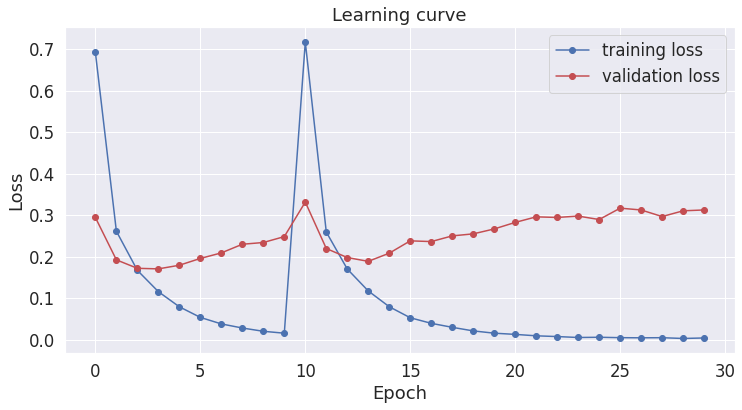

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values[:30], 'b-o', label="training loss")
plt.plot(validation_loss_values[:30], 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [35]:
model = BertForTokenClassification.from_pretrained(BERT_kaust + "/gold_word_events_only_main_synced.bin", num_labels=len(tag2idx), output_attentions = False, output_hidden_states = False)
#model = BertForTokenC

In [36]:
output = model(val_inputs)

In [37]:
preds = [list(p) for p in np.argmax(logits, axis=2)]
pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
print(pred_tags)

['O', 'O', 'B-EVENT_OCCURRENCE', 'B-EVENT_OCCURRENCE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-EVENT_OCCURRENCE', 'O', 'O', 'O', 'O', 'O', 'O', 'B-EVENT_ASPECTUAL', 'B-EVENT_OCCURRENCE', 'O', 'O', 'O', 'O', 'O', 'B-EVENT_I_STATE', 'B-EVENT_STATE', 'O', 'O', 'O', 'O', 'O', 'O', 'B-EVENT_MODAL', 'O', 'O', 'B-EVENT_OCCURRENCE', 'O', 'O', 'O', 'B-EVENT_OCCURRENCE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-EVENT_STATE', 'O', 'O', 'O', 'O', 'B-EVENT_STATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-EVENT_OCCURRENCE', 'B-EVENT_OCCURRENCE', 'B-EVENT_STATE', 'O', 'O', 'O', 'O', 'B-EVENT_STATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-EVENT_REPORTING', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-EVENT_OCCURRENCE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-EVENT_OCCURRENCE', 'O', 'O', 'O', 'B-EVENT_OCCURRENCE', 'B-EVENT_OCCURRENCE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-EVENT_STATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

In [38]:
laetud_artiklid.sort(key=lambda x: x.meta.get("filename"))
laetud_artiklid[5]

Text(text='20.11.2002 Suvel põhjaliku remondi läbi teinud Kanepi kirikutornis troonib nüüdsest endise risti asemel ao- ehk koidutäht . Kanepi koguduse õpetaja Margit Laili sõnul ei ole aotähte Eestis ühegi teise kiriku peatornis . Aotäht kõrgus tornis juba kiriku pühitsemise ajal 1810 , kuid see raudplekist täht ei pidanud ilmastikule sajanditki vastu . Aastast 1893 kuni tänavuse suveni oli tornis rist . " Tähte kirikutornis seostatakse siinsete mõisnike Ungern- Sternbergidega , nende nimi Sternberg tähendab tõlkes tähemäge ja nii nad lasknud tähe tornitippu panemiseks oma kulu ja kirjadega valmistada , " teab Lail üht oletust . Vastne täht valmistati Rein Mõtuse töökojas Tallinnas täpselt sarnane algse aotähega , mis eelmisel aastal kirikutornist üles leiti . Lisaks tähele torni tippu sai uue vaskse kuue tornikiiver , millel vahetati enne välja pehkinud puiduosi talastikus . Margit Laili teadmisel läksid tööd maksma kokku üle poole miljoni krooni , kusjuures koguduse enda kulutused piirdusid vaid remondiaegsete elektrikuludega . Raha tuli muinsuskaitseameti kaudu Eesti riigilt , tööd tegi osaühing Frantsiskus .')

# Tulemused

## 9 epochs, muu default

------------------------------------ gold_word_events ------------------------------------  
Average train loss: 0.027489389479160308  

Epoch: 100%|██████████| 9/9 [02:37<00:00, 17.50s/it]  

Validation loss: 0.1894942492246628  
Validation Accuracy: 0.9537800071658904  
Validation Precision: 0.8715415019762845  
Validation Recall: 0.8513513513513513  
Validation F1-Score: 0.861328125  

------------------------------------ gold_word_events_w_classes ------------------------------------  
Average train loss: 0.08656185688450932  

Epoch: 100%|██████████| 9/9 [02:37<00:00, 17.50s/it]  

Validation loss: 0.2764622956514359  
Validation Accuracy: 0.9344321031888212  
Validation Precision: 0.7608695652173914  
Validation Recall: 0.7375478927203065  
Validation F1-Score: 0.7490272373540856  

------------------------------------ gold_word_events_only_main ------------------------------------  
Average train loss: 0.0520309398882091  

Epoch: 100%|██████████| 9/9 [02:37<00:00, 17.52s/it]  

Validation loss: 0.21417713463306426  
Validation Accuracy: 0.9448226442135436  
Validation Precision: 0.782520325203252  
Validation Recall: 0.7715430861723447  
Validation F1-Score: 0.7769929364278506  

===================================================  
------------------------------------ gold_word_events_synced ------------------------------------  
Average train loss: 0.025615402148105204  

Epoch: 100%|██████████| 9/9 [02:35<00:00, 17.22s/it]  

Validation loss: 0.15242615938186646  
Validation Accuracy: 0.9551166965888689  
Validation Precision: 0.8884297520661157  
Validation Recall: 0.8414872798434442  
Validation F1-Score: 0.8643216080402011  

------------------------------------ gold_word_events_w_classes_synced ------------------------------------  
Average train loss: 0.09057028749957681  

Epoch: 100%|██████████| 9/9 [02:33<00:00, 17.08s/it]  

Validation loss: 0.23032740652561187  
Validation Accuracy: 0.933931777378815  
Validation Precision: 0.7851239669421488  
Validation Recall: 0.7265774378585086  
Validation F1-Score: 0.7547169811320755  

------------------------------------ gold_word_events_only_main_synced ------------------------------------  

Average train loss: 0.05715969391167164  

Epoch: 100%|██████████| 9/9 [02:38<00:00, 17.59s/it]  

Validation loss: 0.16708420515060424  
Validation Accuracy: 0.9500897666068223  
Validation Precision: 0.811965811965812  
Validation Recall: 0.7883817427385892  
Validation F1-Score: 0.7999999999999999  







## gold_word_events_synced

### early stopping f1_score
epochs = 40  
patience = 5

Keskmised  
**Accuracy 0.9551755768621935**  

> [0.9610516066212269, 0.9531828898619064, 0.9525458953931417, 0.9499314128943759, 0.9527389903329753, 0.9586324786324786, 0.9527260179434093, 0.9561615464273386, 0.9580125962211337, 0.9567723342939481]

**Precision 0.891699925908617**  

> [0.8912213740458015, 0.8590225563909775, 0.8951456310679612, 0.8957055214723927, 0.8876190476190476, 0.876953125, 0.8815533980582524, 0.9195876288659793, 0.9047619047619048, 0.9054290718038529]

**Recall 0.8713194854825945**  

> [0.880859375, 0.8792079207920792, 0.8779527559055118, 0.8106995884773662, 0.8725490196078431, 0.883399209486166, 0.8734939759036144, 0.8824742268041237, 0.8858921161825726, 0.8666666666666667]

**F1_score 0.8725215717439129**  

> [0.8706563706563706, 0.865530303030303, 0.8719452590420332, 0.8504854368932039, 0.8767638758231421, 0.8781925343811394, 0.8697318007662834, 0.8824742268041237, 0.8845437616387338, 0.8748921484037964]

**Early stopid** [12, 6, 11, 8, 16, 7, 17, 23, 19, 10]

**Kõigi ristvalideerimiste mudelite ennustuste järgi**

Validation Accuracy: 0.9552254063447712  
Validation Precision: 0.879838243789717  
Validation Recall: 0.8653409090909091  
Validation F1-Score: 0.8725293612145516  

### Nervaluate

{'ent_type': 
{'actual': 5280,  
&emsp;'correct': 4690,  
&emsp;'f1': 0.8956363983576818,  
&emsp;'incorrect': 0,  
&emsp;'missed': 503,  
&emsp;'partial': 0,  
&emsp;'possible': 5193,  
&emsp;'precision': 0.8882575757575758,  
&emsp;'recall': 0.9031388407471597,  
&emsp;'spurious': 590},  
 'exact': {'actual': 5280,  
&emsp;'correct': 4569,  
&emsp;'f1': 0.8725293612145516,  
&emsp;'incorrect': 121,  
&emsp;'missed': 503,  
&emsp;'partial': 0,  
&emsp;'possible': 5193,  
&emsp;'precision': 0.8653409090909091,  
&emsp;'recall': 0.879838243789717,  
&emsp;'spurious': 590},  
 'partial': {'actual': 5280,  
&emsp;'correct': 4569,  
&emsp;'f1': 0.8840828797861167,  
&emsp;'incorrect': 0,  
&emsp;'missed': 503,  
&emsp;'partial': 121,  
&emsp;'possible': 5193,  
&emsp;'precision': 0.8767992424242425,  
&emsp;'recall': 0.8914885422684383,  
&emsp;'spurious': 590},  
 'strict': {'actual': 5280,  
&emsp;'correct': 4569,  
&emsp;'f1': 0.8725293612145516,  
&emsp;'incorrect': 121,  
&emsp;'missed': 503,  
&emsp;'partial': 0,  
&emsp;'possible': 5193,  
&emsp;'precision': 0.8653409090909091,  
&emsp;'recall': 0.879838243789717,  
&emsp;'spurious': 590}}

By tags

## gold_word_events_synced, early stopping validation_loss
epochs = 20  
patience = 5

Keskmised  
**Accuracy 0.9485490701972651**  
> [0.9463788300835655, 0.9450392576730906, 0.948178391959799, 0.9585914574502772, 0.9547920433996383, 0.9447165850244926, 0.9426582698044415, 0.9467680608365019, 0.9519914651493598, 0.9463763405914852]  

**Precision 0.8456206986325201**  
> [0.8172484599589322, 0.8387755102040816, 0.8739352640545145, 0.8666666666666667, 0.8509803921568627, 0.8667883211678832, 0.7897727272727273, 0.8509433962264151, 0.8650306748466258, 0.8360655737704918]  

**Recall 0.8637911708983937**  
> [0.8674698795180723, 0.8986175115207373, 0.8493377483443708, 0.8913043478260869, 0.8839103869653768, 0.8374558303886925, 0.8492871690427699, 0.8796498905908097, 0.8409542743538767, 0.839924670433145]  

**F1_score 0.8480520956699401**  
> [0.8378947368421052, 0.8456790123456789, 0.8614609571788413, 0.868421052631579, 0.8671328671328671, 0.8509874326750448, 0.8184494602551522, 0.8517469310670445, 0.8528225806451611, 0.825925925925926]  

**Early stopid** [4, 4, 4, 5, 5, 4, 3, 4, 4, 4]  

## gold_word_events_w_classes_synced

### early stopping f1_score
epochs = 40  
patience = 5

Keskmised  
**Accuracy 0.9346251273648667**  
> [0.9428756897111328, 0.9356685752778713, 0.9293384135781088, 0.9276406035665294, 0.9366272824919442, 0.9374358974358974, 0.9299516908212561, 0.9399378667587159, 0.9356193142057383, 0.9311559398014729]

**Precision 0.7741527861414685**  
> [0.7843511450381679, 0.7823639774859287, 0.7717601547388782, 0.7728194726166329, 0.7821969696969697, 0.7602339181286549, 0.7596899224806202, 0.7880658436213992, 0.7752380952380953, 0.764808362369338]

**Recall 0.7585364061654911**  
> [0.7843511450381679, 0.7877629063097514, 0.7367387033398821, 0.7072691552062869, 0.785171102661597, 0.7871900826446281, 0.7340823970037453, 0.766, 0.7556818181818182, 0.7411167512690355]

**F1_score 0.762296249983915**  
> [0.7843511450381679, 0.7803030303030303, 0.7492957746478874, 0.7257142857142859, 0.7836812144212523, 0.7642928786359078, 0.7466666666666666, 0.7768762677484787, 0.7598499061913696, 0.751931330472103]

**Early stopid** [14, 15, 7, 9, 20, 7, 10, 22, 19, 8]

**Kõigi ristvalideerimiste ennustuste järgi**  
Validation Accuracy: 0.9344396360786452  
Validation Precision: 0.7707813399884815  
Validation Recall: 0.753566066066066  
Validation F1-Score: 0.7620764923602544  

### Nervaluate

{'ent_type':   
{'actual': 5328,  
&emsp;'correct': 4113,  
&emsp;'f1': 0.7806776122235929,  
&emsp;'incorrect': 595,  
&emsp;'missed': 501,  
&emsp;'partial': 0,  
&emsp;'possible': 5209,  
&emsp;'precision': 0.7719594594594594,  
&emsp;'recall': 0.7895949318487233,  
&emsp;'spurious': 620},  
 'exact': {'actual': 5328,  
&emsp;'correct': 4584,  
&emsp;'f1': 0.8700768719749454,  
&emsp;'incorrect': 124,  
&emsp;'missed': 501,  
&emsp;'partial': 0,  
&emsp;'possible': 5209,  
&emsp;'precision': 0.8603603603603603,  
&emsp;'recall': 0.8800153580341716,  
&emsp;'spurious': 620},  
 'partial': {'actual': 5328,  
&emsp;'correct': 4584,  
&emsp;'f1': 0.8818449273986904,  
&emsp;'incorrect': 0,  
&emsp;'missed': 501,  
&emsp;'partial': 124,  
&emsp;'possible': 5209,  
&emsp;'precision': 0.871996996996997,  
&emsp;'recall': 0.8919178345171818,  
&emsp;'spurious': 620},  
 'strict': {'actual': 5328,  
&emsp;'correct': 4015,  
&emsp;'f1': 0.7620764923602544,  
&emsp;'incorrect': 693,  
&emsp;'missed': 501,  
&emsp;'partial': 0,  
&emsp;'possible': 5209,  
&emsp;'precision': 0.753566066066066,  
&emsp;'recall': 0.7707813399884815,  
&emsp;'spurious': 620}}  

### Nervaluate by tag
{'EVENT_ASPECTUAL': {'ent_type': {'actual': 208,  
&emsp;'correct': 124,  
&emsp;'f1': 0.5821596244131455,  
&emsp;'incorrect': 74,  
&emsp;'missed': 20,  
&emsp;'partial': 0,  
&emsp;'possible': 218,  
&emsp;'precision': 0.5961538461538461,  
&emsp;'recall': 0.5688073394495413,  
&emsp;'spurious': 10},  
  'exact': {'actual': 208,  
&emsp;'correct': 194,  
&emsp;'f1': 0.9107981220657276,  
&emsp;'incorrect': 4,  
&emsp;'missed': 20,  
&emsp;'partial': 0,  
&emsp;'possible': 218,  
&emsp;'precision': 0.9326923076923077,  
&emsp;'recall': 0.8899082568807339,  
&emsp;'spurious': 10},  
  'partial': {'actual': 208,  
&emsp;'correct': 194,  
&emsp;'f1': 0.92018779342723,  
&emsp;'incorrect': 0,  
&emsp;'missed': 20,  
&emsp;'partial': 4,  
&emsp;'possible': 218,  
&emsp;'precision': 0.9423076923076923,  
&emsp;'recall': 0.8990825688073395,  
&emsp;'spurious': 10},  
  'strict': {'actual': 208,  
&emsp;'correct': 124,  
&emsp;'f1': 0.5821596244131455,  
&emsp;'incorrect': 74,  
&emsp;'missed': 20,  
&emsp;'partial': 0,  
&emsp;'possible': 218,  
&emsp;'precision': 0.5961538461538461,  
&emsp;'recall': 0.5688073394495413,  
&emsp;'spurious': 10}},  
 'EVENT_I_ACTION': {'ent_type': {'actual': 628,  
&emsp;'correct': 350,  
&emsp;'f1': 0.5564387917329093,  
&emsp;'incorrect': 270,  
&emsp;'missed': 10,  
&emsp;'partial': 0,  
&emsp;'possible': 630,  
&emsp;'precision': 0.5573248407643312,  
&emsp;'recall': 0.5555555555555556,  
&emsp;'spurious': 8},  
  'exact': {'actual': 628,  
&emsp;'correct': 610,  
&emsp;'f1': 0.9697933227344991,  
&emsp;'incorrect': 10,  
&emsp;'missed': 10,  
&emsp;'partial': 0,  
&emsp;'possible': 630,  
&emsp;'precision': 0.9713375796178344,  
&emsp;'recall': 0.9682539682539683,  
&emsp;'spurious': 8},  
  'partial': {'actual': 628,  
&emsp;'correct': 610,  
&emsp;'f1': 0.9777424483306836,  
&emsp;'incorrect': 0,  
&emsp;'missed': 10,  
&emsp;'partial': 10,  
&emsp;'possible': 630,  
&emsp;'precision': 0.9792993630573248,  
&emsp;'recall': 0.9761904761904762,  
&emsp;'spurious': 8},  
  'strict': {'actual': 628,  
&emsp;'correct': 346,  
&emsp;'f1': 0.5500794912559619,  
&emsp;'incorrect': 274,  
&emsp;'missed': 10,  
&emsp;'partial': 0,  
&emsp;'possible': 630,  
&emsp;'precision': 0.5509554140127388,  
&emsp;'recall': 0.5492063492063493,  
&emsp;'spurious': 8}},  
 'EVENT_I_STATE': {'ent_type': {'actual': 492,  
&emsp;'correct': 310,  
&emsp;'f1': 0.6288032454361054,  
&emsp;'incorrect': 158,  
&emsp;'missed': 26,  
&emsp;'partial': 0,  
&emsp;'possible': 494,  
&emsp;'precision': 0.6300813008130082,  
&emsp;'recall': 0.6275303643724697,  
&emsp;'spurious': 24},  
  'exact': {'actual': 492,  
&emsp;'correct': 462,  
&emsp;'f1': 0.9371196754563895,  
&emsp;'incorrect': 6,  
&emsp;'missed': 26,  
&emsp;'partial': 0,  
&emsp;'possible': 494,  
&emsp;'precision': 0.9390243902439024,  
&emsp;'recall': 0.9352226720647774,  
&emsp;'spurious': 24},  
  'partial': {'actual': 492,  
&emsp;'correct': 462,  
&emsp;'f1': 0.9432048681541582,  
&emsp;'incorrect': 0,  
&emsp;'missed': 26,  
&emsp;'partial': 6,  
&emsp;'possible': 494,  
&emsp;'precision': 0.9451219512195121,  
&emsp;'recall': 0.9412955465587044,  
&emsp;'spurious': 24},  
  'strict': {'actual': 492,  
&emsp;'correct': 308,  
&emsp;'f1': 0.6247464503042597,  
&emsp;'incorrect': 160,  
&emsp;'missed': 26,  
&emsp;'partial': 0,  
&emsp;'possible': 494,  
&emsp;'precision': 0.6260162601626016,  
&emsp;'recall': 0.6234817813765182,  
&emsp;'spurious': 24}},  
 'EVENT_MODAL': {'ent_type': {'actual': 165,  
&emsp;'correct': 160,  
&emsp;'f1': 0.9667673716012085,  
&emsp;'incorrect': 5,  
&emsp;'missed': 1,  
&emsp;'partial': 0,  
&emsp;'possible': 166,  
&emsp;'precision': 0.9696969696969697,  
&emsp;'recall': 0.963855421686747,  
&emsp;'spurious': 0},  
  'exact': {'actual': 165,  
&emsp;'correct': 165,  
&emsp;'f1': 0.9969788519637462,  
&emsp;'incorrect': 0,  
&emsp;'missed': 1,  
&emsp;'partial': 0,  
&emsp;'possible': 166,  
&emsp;'precision': 1.0,  
&emsp;'recall': 0.9939759036144579,  
&emsp;'spurious': 0},  
  'partial': {'actual': 165,  
&emsp;'correct': 165,  
&emsp;'f1': 0.9969788519637462,  
&emsp;'incorrect': 0,  
&emsp;'missed': 1,  
&emsp;'partial': 0,  
&emsp;'possible': 166,  
&emsp;'precision': 1.0,  
&emsp;'recall': 0.9939759036144579,  
&emsp;'spurious': 0},  
  'strict': {'actual': 165,  
&emsp;'correct': 160,  
&emsp;'f1': 0.9667673716012085,  
&emsp;'incorrect': 5,  
&emsp;'missed': 1,  
&emsp;'partial': 0,  
&emsp;'possible': 166,  
&emsp;'precision': 0.9696969696969697,  
&emsp;'recall': 0.963855421686747,  
&emsp;'spurious': 0}},  
 'EVENT_OCCURRENCE': {'ent_type': {'actual': 6540,  
&emsp;'correct': 5332,  
&emsp;'f1': 0.8261543229005268,  
&emsp;'incorrect': 314,  
&emsp;'missed': 722,  
&emsp;'partial': 0,  
&emsp;'possible': 6368,  
&emsp;'precision': 0.8152905198776759,  
&emsp;'recall': 0.8373115577889447,  
&emsp;'spurious': 894},  
  'exact': {'actual': 6540,  
&emsp;'correct': 5572,  
&emsp;'f1': 0.8633405639913232,  
&emsp;'incorrect': 74,  
&emsp;'missed': 722,  
&emsp;'partial': 0,  
&emsp;'possible': 6368,  
&emsp;'precision': 0.8519877675840979,  
&emsp;'recall': 0.875,  
&emsp;'spurious': 894},  
  'partial': {'actual': 6540,  
&emsp;'correct': 5572,  
&emsp;'f1': 0.8690734428261543,  
&emsp;'incorrect': 0,  
&emsp;'missed': 722,  
&emsp;'partial': 74,  
&emsp;'possible': 6368,  
&emsp;'precision': 0.8576452599388379,  
&emsp;'recall': 0.8808103015075377,  
&emsp;'spurious': 894},  
  'strict': {'actual': 6540,  
&emsp;'correct': 5276,  
&emsp;'f1': 0.8174775333126744,  
&emsp;'incorrect': 370,  
&emsp;'missed': 722,  
&emsp;'partial': 0,  
&emsp;'possible': 6368,  
&emsp;'precision': 0.8067278287461773,  
&emsp;'recall': 0.8285175879396985,  
&emsp;'spurious': 894}},  
 'EVENT_PERCEPTION': {'ent_type': {'actual': 19,  
&emsp;'correct': 0,  
&emsp;'f1': 0,  
&emsp;'incorrect': 18,  
&emsp;'missed': 0,  
&emsp;'partial': 0,  
&emsp;'possible': 18,  
&emsp;'precision': 0.0,  
&emsp;'recall': 0.0,  
&emsp;'spurious': 1},  
  'exact': {'actual': 19,  
&emsp;'correct': 18,  
&emsp;'f1': 0.972972972972973,  
&emsp;'incorrect': 0,  
&emsp;'missed': 0,  
&emsp;'partial': 0,  
&emsp;'possible': 18,  
&emsp;'precision': 0.9473684210526315,  
&emsp;'recall': 1.0,  
&emsp;'spurious': 1},  
  'partial': {'actual': 19,  
&emsp;'correct': 18,  
&emsp;'f1': 0.972972972972973,  
&emsp;'incorrect': 0,  
&emsp;'missed': 0,  
&emsp;'partial': 0,  
&emsp;'possible': 18,  
&emsp;'precision': 0.9473684210526315,  
&emsp;'recall': 1.0,  
&emsp;'spurious': 1},  
  'strict': {'actual': 19,  
&emsp;'correct': 0,  
&emsp;'f1': 0,  
&emsp;'incorrect': 18,  
&emsp;'missed': 0,  
&emsp;'partial': 0,  
&emsp;'possible': 18,  
&emsp;'precision': 0.0,  
&emsp;'recall': 0.0,  
&emsp;'spurious': 1}},  
 'EVENT_REPORTING': {'ent_type': {'actual': 278,  
&emsp;'correct': 242,  
&emsp;'f1': 0.8720720720720722,  
&emsp;'incorrect': 34,  
&emsp;'missed': 1,  
&emsp;'partial': 0,  
&emsp;'possible': 277,  
&emsp;'precision': 0.8705035971223022,  
&emsp;'recall': 0.8736462093862816,  
&emsp;'spurious': 2},  
  'exact': {'actual': 278,  
&emsp;'correct': 276,  
&emsp;'f1': 0.9945945945945946,  
&emsp;'incorrect': 0,  
&emsp;'missed': 1,  
&emsp;'partial': 0,  
&emsp;'possible': 277,  
&emsp;'precision': 0.9928057553956835,  
&emsp;'recall': 0.9963898916967509,  
&emsp;'spurious': 2},  
  'partial': {'actual': 278,  
&emsp;'correct': 276,  
&emsp;'f1': 0.9945945945945946,  
&emsp;'incorrect': 0,  
&emsp;'missed': 1,  
&emsp;'partial': 0,  
&emsp;'possible': 277,  
&emsp;'precision': 0.9928057553956835,  
&emsp;'recall': 0.9963898916967509,  
&emsp;'spurious': 2},  
  'strict': {'actual': 278,  
&emsp;'correct': 242,  
&emsp;'f1': 0.8720720720720722,  
&emsp;'incorrect': 34,  
&emsp;'missed': 1,  
&emsp;'partial': 0,  
&emsp;'possible': 277,  
&emsp;'precision': 0.8705035971223022,  
&emsp;'recall': 0.8736462093862816,  
&emsp;'spurious': 2}},  
 'EVENT_STATE': {'ent_type': {'actual': 1864,  
&emsp;'correct': 1306,  
&emsp;'f1': 0.7156164383561644,  
&emsp;'incorrect': 260,  
&emsp;'missed': 220,  
&emsp;'partial': 0,  
&emsp;'possible': 1786,  
&emsp;'precision': 0.7006437768240343,  
&emsp;'recall': 0.7312430011198209,  
&emsp;'spurious': 298},  
  'exact': {'actual': 1864,  
&emsp;'correct': 1412,  
&emsp;'f1': 0.7736986301369863,  
&emsp;'incorrect': 154,  
&emsp;'missed': 220,  
&emsp;'partial': 0,  
&emsp;'possible': 1786,  
&emsp;'precision': 0.7575107296137339,  
&emsp;'recall': 0.7905935050391937,  
&emsp;'spurious': 298},  
  'partial': {'actual': 1864,  
&emsp;'correct': 1412,  
&emsp;'f1': 0.815890410958904,  
&emsp;'incorrect': 0,  
&emsp;'missed': 220,  
&emsp;'partial': 154,  
&emsp;'possible': 1786,  
&emsp;'precision': 0.7988197424892703,  
&emsp;'recall': 0.8337066069428891,  
&emsp;'spurious': 298},  
  'strict': {'actual': 1864,  
&emsp;'correct': 1172,  
&emsp;'f1': 0.6421917808219179,  
&emsp;'incorrect': 394,  
&emsp;'missed': 220,  
&emsp;'partial': 0,  
&emsp;'possible': 1786,  
&emsp;'precision': 0.628755364806867,  
&emsp;'recall': 0.6562150055991042,  
&emsp;'spurious': 298}}}  

## gold_word_events_only_main_synced, early stopping f1_score
epochs = 40  
patience = 5

Keskmised  
**Accuracy 0.9461027191058656**  
> [0.9535864978902954, 0.9498147524418996, 0.941808105299619, 0.9423868312757202, 0.9462943071965628, 0.948034188034188, 0.9492753623188406, 0.947877114256127, 0.9408677396780966, 0.941082292667307]

**Precision 0.7966357268554684**  
> [0.7937743190661478, 0.8070175438596491, 0.8032128514056225, 0.8021276595744681, 0.801980198019802, 0.7631578947368421, 0.8223552894211577, 0.7978494623655914, 0.7701375245579568, 0.8047445255474452]

**Recall 0.7895064054200279**  
> [0.8172268907563025, 0.8207171314741036, 0.7615384615384615, 0.7423312883435583, 0.8157894736842105, 0.8096280087527352, 0.8089430894308943, 0.7746781115879828, 0.7701375245579568, 0.774074074074074]

**F1_score 0.7874847459082727**  
> [0.8047337278106509, 0.8118226600985223, 0.7779960707269155, 0.763157894736842, 0.8035714285714285, 0.7781282860147213, 0.8023369036027264, 0.7851851851851852, 0.7701375245579568, 0.7777777777777778]

**Early stopid** [5, 41, 7, 11, 9, 7, 10, 9, 8, 8]

**Kõigi ristvalideerimiste ennustuste järgi**  
Validation Accuracy: 0.9457866221419566  
Validation Precision: 0.7941000597966913  
Validation Recall: 0.7810233287590669  
Validation F1-Score: 0.787507412532121  

### Nervaluate

{'ent_type': {'actual': 5101,  
&emsp;'correct': 3984,  
&emsp;'f1': 0.787507412532121,  
&emsp;'incorrect': 559,  
&emsp;'missed': 474,  
&emsp;'partial': 0,  
&emsp;'possible': 5017,  
&emsp;'precision': 0.7810233287590669,  
&emsp;'recall': 0.7941000597966913,  
&emsp;'spurious': 558},  
 'exact': {'actual': 5101,  
&emsp;'correct': 4543,  
&emsp;'f1': 0.8980035580154181,  
&emsp;'incorrect': 0,  
&emsp;'missed': 474,  
&emsp;'partial': 0,  
&emsp;'possible': 5017,  
&emsp;'precision': 0.8906096843756126,  
&emsp;'recall': 0.9055212278253937,  
&emsp;'spurious': 558},  
 'partial': {'actual': 5101,  
&emsp;'correct': 4543,  
&emsp;'f1': 0.8980035580154181,  
&emsp;'incorrect': 0,  
&emsp;'missed': 474,  
&emsp;'partial': 0,  
&emsp;'possible': 5017,  
&emsp;'precision': 0.8906096843756126,  
&emsp;'recall': 0.9055212278253937,  
&emsp;'spurious': 558},  
 'strict': {'actual': 5101,  
&emsp;'correct': 3984,  
&emsp;'f1': 0.787507412532121,  
&emsp;'incorrect': 559,  
&emsp;'missed': 474,  
&emsp;'partial': 0,  
&emsp;'possible': 5017,  
&emsp;'precision': 0.7810233287590669,  
&emsp;'recall': 0.7941000597966913,  
&emsp;'spurious': 558}}  


###Nervaluate by tag
{'EVENT_ASPECTUAL': {'ent_type': {'actual': 102  
&emsp;&emsp;'correct': 61  
&emsp;&emsp;'f1': 0.5781990521327014  
&emsp;&emsp;'incorrect': 38  
&emsp;&emsp;'missed': 10  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 109  
&emsp;&emsp;'precision': 0.5980392156862745  
&emsp;&emsp;'recall': 0.5596330275229358  
&emsp;&emsp;'spurious': 3}  
&emsp;'exact': {'actual': 102  
&emsp;&emsp;'correct': 99  
&emsp;&emsp;'f1': 0.9383886255924171  
&emsp;&emsp;'incorrect': 0  
&emsp;&emsp;'missed': 10  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 109  
&emsp;&emsp;'precision': 0.9705882352941176  
&emsp;&emsp;'recall': 0.908256880733945  
&emsp;&emsp;'spurious': 3}  
&emsp;'partial': {'actual': 102  
&emsp;&emsp;'correct': 99  
&emsp;&emsp;'f1': 0.9383886255924171  
&emsp;&emsp;'incorrect': 0  
&emsp;&emsp;'missed': 10  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 109  
&emsp;&emsp;'precision': 0.9705882352941176  
&emsp;&emsp;'recall': 0.908256880733945  
&emsp;&emsp;'spurious': 3}  
&emsp;'strict': {'actual': 102  
&emsp;&emsp;'correct': 61  
&emsp;&emsp;'f1': 0.5781990521327014  
&emsp;&emsp;'incorrect': 38  
&emsp;&emsp;'missed': 10  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 109  
&emsp;&emsp;'precision': 0.5980392156862745  
&emsp;&emsp;'recall': 0.5596330275229358  
&emsp;&emsp;'spurious': 3}}  
 'EVENT_I_ACTION': {'ent_type': {'actual': 305  
&emsp;&emsp;'correct': 153  
&emsp;&emsp;'f1': 0.49918433931484507  
&emsp;&emsp;'incorrect': 148  
&emsp;&emsp;'missed': 7  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 308  
&emsp;&emsp;'precision': 0.5016393442622951  
&emsp;&emsp;'recall': 0.4967532467532468  
&emsp;&emsp;'spurious': 4}  
&emsp;'exact': {'actual': 305  
&emsp;&emsp;'correct': 301  
&emsp;&emsp;'f1': 0.9820554649265907  
&emsp;&emsp;'incorrect': 0  
&emsp;&emsp;'missed': 7  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 308  
&emsp;&emsp;'precision': 0.9868852459016394  
&emsp;&emsp;'recall': 0.9772727272727273  
&emsp;&emsp;'spurious': 4}  
&emsp;'partial': {'actual': 305  
&emsp;&emsp;'correct': 301  
&emsp;&emsp;'f1': 0.9820554649265907  
&emsp;&emsp;'incorrect': 0  
&emsp;&emsp;'missed': 7  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 308  
&emsp;&emsp;'precision': 0.9868852459016394  
&emsp;&emsp;'recall': 0.9772727272727273  
&emsp;&emsp;'spurious': 4}  
&emsp;'strict': {'actual': 305  
&emsp;&emsp;'correct': 153  
&emsp;&emsp;'f1': 0.49918433931484507  
&emsp;&emsp;'incorrect': 148  
&emsp;&emsp;'missed': 7  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 308  
&emsp;&emsp;'precision': 0.5016393442622951  
&emsp;&emsp;'recall': 0.4967532467532468  
&emsp;&emsp;'spurious': 4}}  
 'EVENT_I_STATE': {'ent_type': {'actual': 226  
&emsp;&emsp;'correct': 154  
&emsp;&emsp;'f1': 0.6710239651416122  
&emsp;&emsp;'incorrect': 62  
&emsp;&emsp;'missed': 17  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 233  
&emsp;&emsp;'precision': 0.6814159292035398  
&emsp;&emsp;'recall': 0.6609442060085837  
&emsp;&emsp;'spurious': 10}  
&emsp;'exact': {'actual': 226  
&emsp;&emsp;'correct': 216  
&emsp;&emsp;'f1': 0.9411764705882353  
&emsp;&emsp;'incorrect': 0  
&emsp;&emsp;'missed': 17  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 233  
&emsp;&emsp;'precision': 0.9557522123893806  
&emsp;&emsp;'recall': 0.927038626609442  
&emsp;&emsp;'spurious': 10}  
&emsp;'partial': {'actual': 226  
&emsp;&emsp;'correct': 216  
&emsp;&emsp;'f1': 0.9411764705882353  
&emsp;&emsp;'incorrect': 0  
&emsp;&emsp;'missed': 17  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 233  
&emsp;&emsp;'precision': 0.9557522123893806  
&emsp;&emsp;'recall': 0.927038626609442  
&emsp;&emsp;'spurious': 10}  
&emsp;'strict': {'actual': 226  
&emsp;&emsp;'correct': 154  
&emsp;&emsp;'f1': 0.6710239651416122  
&emsp;&emsp;'incorrect': 62  
&emsp;&emsp;'missed': 17  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 233  
&emsp;&emsp;'precision': 0.6814159292035398  
&emsp;&emsp;'recall': 0.6609442060085837  
&emsp;&emsp;'spurious': 10}}  
 'EVENT_MODAL': {'ent_type': {'actual': 167  
&emsp;&emsp;'correct': 160  
&emsp;&emsp;'f1': 0.9609609609609611  
&emsp;&emsp;'incorrect': 6  
&emsp;&emsp;'missed': 0  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 166  
&emsp;&emsp;'precision': 0.9580838323353293  
&emsp;&emsp;'recall': 0.963855421686747  
&emsp;&emsp;'spurious': 1}  
&emsp;'exact': {'actual': 167  
&emsp;&emsp;'correct': 166  
&emsp;&emsp;'f1': 0.996996996996997  
&emsp;&emsp;'incorrect': 0  
&emsp;&emsp;'missed': 0  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 166  
&emsp;&emsp;'precision': 0.9940119760479041  
&emsp;&emsp;'recall': 1.0  
&emsp;&emsp;'spurious': 1}  
&emsp;'partial': {'actual': 167  
&emsp;&emsp;'correct': 166  
&emsp;&emsp;'f1': 0.996996996996997  
&emsp;&emsp;'incorrect': 0  
&emsp;&emsp;'missed': 0  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 166  
&emsp;&emsp;'precision': 0.9940119760479041  
&emsp;&emsp;'recall': 1.0  
&emsp;&emsp;'spurious': 1}  
&emsp;'strict': {'actual': 167  
&emsp;&emsp;'correct': 160  
&emsp;&emsp;'f1': 0.9609609609609611  
&emsp;&emsp;'incorrect': 6  
&emsp;&emsp;'missed': 0  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 166  
&emsp;&emsp;'precision': 0.9580838323353293  
&emsp;&emsp;'recall': 0.963855421686747  
&emsp;&emsp;'spurious': 1}}  
 'EVENT_OCCURRENCE': {'ent_type': {'actual': 3290  
&emsp;&emsp;'correct': 2682  
&emsp;&emsp;'f1': 0.8327899394503958  
&emsp;&emsp;'incorrect': 142  
&emsp;&emsp;'missed': 327  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 3151  
&emsp;&emsp;'precision': 0.8151975683890578  
&emsp;&emsp;'recall': 0.8511583624246271  
&emsp;&emsp;'spurious': 466}  
&emsp;'exact': {'actual': 3290  
&emsp;&emsp;'correct': 2824  
&emsp;&emsp;'f1': 0.8768824716658904  
&emsp;&emsp;'incorrect': 0  
&emsp;&emsp;'missed': 327  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 3151  
&emsp;&emsp;'precision': 0.8583586626139817  
&emsp;&emsp;'recall': 0.8962234211361473  
&emsp;&emsp;'spurious': 466}  
&emsp;'partial': {'actual': 3290  
&emsp;&emsp;'correct': 2824  
&emsp;&emsp;'f1': 0.8768824716658904  
&emsp;&emsp;'incorrect': 0  
&emsp;&emsp;'missed': 327  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 3151  
&emsp;&emsp;'precision': 0.8583586626139817  
&emsp;&emsp;'recall': 0.8962234211361473  
&emsp;&emsp;'spurious': 466}  
&emsp;'strict': {'actual': 3290  
&emsp;&emsp;'correct': 2682  
&emsp;&emsp;'f1': 0.8327899394503958  
&emsp;&emsp;'incorrect': 142  
&emsp;&emsp;'missed': 327  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 3151  
&emsp;&emsp;'precision': 0.8151975683890578  
&emsp;&emsp;'recall': 0.8511583624246271  
&emsp;&emsp;'spurious': 466}}  
 'EVENT_PERCEPTION': {'ent_type': {'actual': 18  
&emsp;&emsp;'correct': 0  
&emsp;&emsp;'f1': 0  
&emsp;&emsp;'incorrect': 18  
&emsp;&emsp;'missed': 0  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 18  
&emsp;&emsp;'precision': 0.0  
&emsp;&emsp;'recall': 0.0  
&emsp;&emsp;'spurious': 0}  
&emsp;'exact': {'actual': 18  
&emsp;&emsp;'correct': 18  
&emsp;&emsp;'f1': 1.0  
&emsp;&emsp;'incorrect': 0  
&emsp;&emsp;'missed': 0  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 18  
&emsp;&emsp;'precision': 1.0  
&emsp;&emsp;'recall': 1.0  
&emsp;&emsp;'spurious': 0}  
&emsp;'partial': {'actual': 18  
&emsp;&emsp;'correct': 18  
&emsp;&emsp;'f1': 1.0  
&emsp;&emsp;'incorrect': 0  
&emsp;&emsp;'missed': 0  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 18  
&emsp;&emsp;'precision': 1.0  
&emsp;&emsp;'recall': 1.0  
&emsp;&emsp;'spurious': 0}  
&emsp;'strict': {'actual': 18  
&emsp;&emsp;'correct': 0  
&emsp;&emsp;'f1': 0  
&emsp;&emsp;'incorrect': 18  
&emsp;&emsp;'missed': 0  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 18  
&emsp;&emsp;'precision': 0.0  
&emsp;&emsp;'recall': 0.0  
&emsp;&emsp;'spurious': 0}}  
 'EVENT_REPORTING': {'ent_type': {'actual': 274  
&emsp;&emsp;'correct': 246  
&emsp;&emsp;'f1': 0.8929219600725952  
&emsp;&emsp;'incorrect': 28  
&emsp;&emsp;'missed': 3  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 277  
&emsp;&emsp;'precision': 0.8978102189781022  
&emsp;&emsp;'recall': 0.8880866425992779  
&emsp;&emsp;'spurious': 0}  
&emsp;'exact': {'actual': 274  
&emsp;&emsp;'correct': 274  
&emsp;&emsp;'f1': 0.9945553539019965  
&emsp;&emsp;'incorrect': 0  
&emsp;&emsp;'missed': 3  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 277  
&emsp;&emsp;'precision': 1.0  
&emsp;&emsp;'recall': 0.9891696750902527  
&emsp;&emsp;'spurious': 0}  
&emsp;'partial': {'actual': 274  
&emsp;&emsp;'correct': 274  
&emsp;&emsp;'f1': 0.9945553539019965  
&emsp;&emsp;'incorrect': 0  
&emsp;&emsp;'missed': 3  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 277  
&emsp;&emsp;'precision': 1.0  
&emsp;&emsp;'recall': 0.9891696750902527  
&emsp;&emsp;'spurious': 0}  
&emsp;'strict': {'actual': 274  
&emsp;&emsp;'correct': 246  
&emsp;&emsp;'f1': 0.8929219600725952  
&emsp;&emsp;'incorrect': 28  
&emsp;&emsp;'missed': 3  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 277  
&emsp;&emsp;'precision': 0.8978102189781022  
&emsp;&emsp;'recall': 0.8880866425992779  
&emsp;&emsp;'spurious': 0}}  
 'EVENT_STATE': {'ent_type': {'actual': 719  
&emsp;&emsp;'correct': 528  
&emsp;&emsp;'f1': 0.7164179104477613  
&emsp;&emsp;'incorrect': 117  
&emsp;&emsp;'missed': 110  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 755  
&emsp;&emsp;'precision': 0.7343532684283728  
&emsp;&emsp;'recall': 0.6993377483443709  
&emsp;&emsp;'spurious': 74}  
&emsp;'exact': {'actual': 719  
&emsp;&emsp;'correct': 645  
&emsp;&emsp;'f1': 0.8751696065128902  
&emsp;&emsp;'incorrect': 0  
&emsp;&emsp;'missed': 110  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 755  
&emsp;&emsp;'precision': 0.8970792767732962  
&emsp;&emsp;'recall': 0.8543046357615894  
&emsp;&emsp;'spurious': 74}  
&emsp;'partial': {'actual': 719  
&emsp;&emsp;'correct': 645  
&emsp;&emsp;'f1': 0.8751696065128902  
&emsp;&emsp;'incorrect': 0  
&emsp;&emsp;'missed': 110  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 755  
&emsp;&emsp;'precision': 0.8970792767732962  
&emsp;&emsp;'recall': 0.8543046357615894  
&emsp;&emsp;'spurious': 74}  
&emsp;'strict': {'actual': 719  
&emsp;&emsp;'correct': 528  
&emsp;&emsp;'f1': 0.7164179104477613  
&emsp;&emsp;'incorrect': 117  
&emsp;&emsp;'missed': 110  
&emsp;&emsp;'partial': 0  
&emsp;&emsp;'possible': 755  
&emsp;&emsp;'precision': 0.7343532684283728  
&emsp;&emsp;'recall': 0.6993377483443709  
&emsp;&emsp;'spurious': 74}}}

In [39]:
print(tr_inputs)

tensor([[ 1177,    15,  1408,  ...,     0,     0,     0],
        [  661, 17036,  5260,  ...,     0,     0,     0],
        [ 3986, 13909,  9621,  ...,     0,     0,     0],
        ...,
        [21155,  6440,  5419,  ...,     0,     0,     0],
        [   95,  4890, 39220,  ...,     0,     0,     0],
        [ 4995, 49887,  2801,  ...,     0,     0,     0]])


In [40]:
print(tr_tags)

tensor([[5, 5, 5,  ..., 9, 9, 9],
        [5, 5, 5,  ..., 9, 9, 9],
        [5, 5, 5,  ..., 9, 9, 9],
        ...,
        [5, 5, 5,  ..., 9, 9, 9],
        [5, 5, 5,  ..., 9, 9, 9],
        [5, 5, 5,  ..., 9, 9, 9]])
